In [63]:
import pandas as pd
from pathlib import Path
import inspect 
import numpy as np
import datetime
import os
import json
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from matplotlib.ticker import MaxNLocator
from dotmap import DotMap
import torch
import torch.nn.init as init
import torch.nn as nn
import pickle
import torch.autograd as autograd
from torchviz import make_dot
from torchsummary import summary
from termcolor import colored
import seaborn as sns
sns.set_theme(style="white", rc={"axes.grid": False})


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics.pairwise import rbf_kernel
from scipy.stats import wasserstein_distance, entropy
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
reserved = int(torch.cuda.max_memory_reserved() / 1000 / 1000)
gpu_available = torch.cuda.is_available()

print(colored(f"GPU available! {torch.cuda.get_device_name()}. Memory reserved: {reserved}MB", "green") if gpu_available else colored("No GPU. Running on CPU", "red"))

GPU available! NVIDIA GeForce RTX 3060. Memory reserved: 0MB


In [3]:
# For Macbook M3
device = "cuda"  # device

## PICK UP WHERE LEFT OFF

**Current Status**
1. Made progress on getting appreciable accuracy on FCNN_night notebook for E0 and rb. MixMaxScaler is the way to go. Since we have no negative value for E0 and rb. Used sigmoid on last layer too.
2. Move that architecture here into Learning Block and see how it performs.
3. Can also try and add a physics based loss on dNEE as regularizer

In [4]:
timestamp = datetime.datetime.now()
timestamp = f"{timestamp.year}-{timestamp.month}-{timestamp.day}_{timestamp.hour}-{timestamp.minute}-{timestamp.second}-{timestamp.microsecond}"

save_dir = Path(timestamp)
if save_dir.exists():
    raise f"Directory exists: {save_dir.as_posix()}"
os.makedirs(save_dir.as_posix())

In [5]:
config = DotMap({"flux_model": "night"})

In [6]:
writer = SummaryWriter(save_dir.joinpath("tensorboard"))

## Model Building and Training

### Data

In [7]:
data = pd.read_parquet("../../PIVAE/PI-VAE-Climate/data_manipulation/final_night_data.parquet")

In [8]:
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]

def split_data_years(df, train_years, test_years, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    train_years (int): Years to include in training data
    test_years (int): Years to include in test data
    
    Returns:
    tuple: Training and test DataFrames.
    """
    
    train_data = df[df.apply(lambda x: x['DateTime'].year in train_years, axis=1)]
    test_data = df[df.apply(lambda x: x['DateTime'].year in test_years, axis=1)]
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)
    
def split_data(df, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    test_size (float): Proportion of the data to include in the test split.
    
    Returns:
    tuple: Training and test DataFrames.
    """
    train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

def physics_nee(k, T, Tref=10, T0=46.02):
    e0 = k[:, 0]
    rb = k[:, 1]
    exp_term = np.exp(e0 * (1.0 / (Tref - T0) - 1.0 / (T - T0)))
    NEE = rb * exp_term
    return NEE

In [9]:
data['year'] = data.DateTime.dt.year

In [10]:
data["NEE_phy"] = physics_nee(data[["E0", "rb"]].values, data.Ta.values)

In [11]:
drivers = np.array(['Ta', 'H', 'Tau', 'LE_strg', 'RH', 'VPD', 'Rg', 'Ustar', 'Tsoil1', 'Tsoil2'])

In [12]:
data, season_feat = set_season_tag(data)
data, time_feat = extract_time_features(data)

In [13]:
data = data[data["dNEE"].notna()].reset_index(drop=True)

In [14]:
drivers = np.concatenate([drivers, [season_feat], time_feat])

In [15]:
columns_to_check_na = np.concatenate([drivers, ["NEE", "dTa"]])

idx = (np.sum(data[columns_to_check_na].notna(), axis=1) == columns_to_check_na.shape[0])
data = data.loc[idx].reset_index(drop=True)

### Training Data 

In [16]:
train_data, test_data = split_data(data)
# train_data, test_data = split_data_years(data, [2012, 2016, 2018], [2015, 2017])

In [17]:
#drivers = np.append(drivers, ["NEE"])
X_train = train_data[drivers]
X_train = train_data[drivers]
NEE_train = train_data["NEE_next"]
T_train = train_data["Ta"]
dT_train = train_data["dTa"]
dNEE_train = train_data["dNEE"]
bNEE_train = train_data["NEE"]
K_train = train_data[["E0", "rb"]]

X_test = test_data[drivers]
NEE_test = test_data["NEE_next"]
T_test = test_data["Ta"]
dT_test = test_data["dTa"]
dNEE_test = test_data["dNEE"]
bNEE_test = test_data["NEE"]
K_test = test_data[["E0", "rb"]]


In [18]:
normalizer_x = StandardScaler()

X_train = normalizer_x.fit_transform(X_train)
X_test = normalizer_x.transform(X_test)


In [19]:
config.data.X = drivers.tolist()
config.data.train_size = X_train.shape[0]
config.data.train_start_date = train_data["DateTime"].iloc[0].ctime()
config.data.train_end_date = train_data["DateTime"].iloc[-1].ctime()
config.data.test_size = X_test.shape[0]
config.data.test_start_date = test_data["DateTime"].iloc[0].ctime()
config.data.test_end_date = test_data["DateTime"].iloc[-1].ctime()

config.data.train_years = np.unique(train_data.DateTime.dt.year).tolist()
config.data.test_years = np.unique(train_data.DateTime.dt.year).tolist()

### Model Building

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_dim, out_dim, activation=nn.ReLU, use_norm=True):
        super(ResidualBlock, self).__init__()
        self.use_projection = (in_dim != out_dim)
        self.fc = nn.Linear(in_dim, out_dim)
        self.activation = activation()
        self.use_norm = use_norm
        if self.use_norm:
            self.norm = nn.BatchNorm1d(out_dim)
        if self.use_projection:
            self.projection = nn.Linear(in_dim, out_dim)
        
    def forward(self, x):
        residual = self.projection(x) if self.use_projection else x
        out = self.fc(x)
        if self.use_norm:
            out = self.norm(out)
        out = self.activation(out)
        return out + residual

class PERNN_night(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_dims, residual_dims, decoder_dims, noise_dims=[4], activation=nn.ReLU, device=device):
        super(PERNN_night, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.residual_dims = residual_dims
        self.activation = activation
        self.device = device
        self.Tref = torch.tensor(10).float().to(self.device)
        self.T0 = torch.tensor(46.02).float().to(self.device)
        self.encoder_dims = encoder_dims
        self.decoder_dims = decoder_dims

        # Encoder network as a stack of residual blocks
        modules = []
        in_dim = input_dim
        for dim in encoder_dims:
            modules.append(ResidualBlock(in_dim, dim, activation=activation, use_norm=True))
            in_dim = dim
        # Map to latent space
        modules.append(nn.Linear(in_dim, latent_dim))
        self.encoder = nn.Sequential(*modules)

        # Decoder network for residual (for residual correction)
        modules = []
        in_dim = latent_dim
        for dim in residual_dims:
            modules.append(ResidualBlock(in_dim, dim, activation=activation, use_norm=True))
            in_dim = dim
        modules.append(nn.Linear(in_dim, 1))
        self.residual = nn.Sequential(*modules)
        
        # Decoder network for NEE (u)
        modules = []
        in_dim = latent_dim
        for dim in decoder_dims:
            modules.append(ResidualBlock(in_dim, dim, activation=activation, use_norm=True))
            in_dim = dim
        modules.append(nn.Linear(in_dim, 1))
        self.nee_decoder = nn.Sequential(*modules)
    
        # Decoder network for dT/dt (f)
        modules = []
        in_dim = latent_dim
        for dim in decoder_dims:
            modules.append(ResidualBlock(in_dim, dim, activation=activation, use_norm=True))
            in_dim = dim
        modules.append(nn.Linear(in_dim, 1))
        self.temp_derivative_decoder = nn.Sequential(*modules)

        # Decoder network for E0 and rb
        modules = []
        in_dim = latent_dim
        # Using LeakyReLU here as in your original code for k_decoder
        for dim in decoder_dims:
            modules.append(ResidualBlock(in_dim, dim, activation=lambda: nn.LeakyReLU(negative_slope=0.01), use_norm=True))
            in_dim = dim
        modules.append(nn.Linear(in_dim, 2))
        modules.append(nn.LeakyReLU(negative_slope=0.01))
        self.k_decoder = nn.Sequential(*modules)

    def forward(self, x, b, k, T):
        input_ = torch.cat((x, b.view(x.shape[0], 1)), dim=1).to(self.device)
        z = self.encoder(input_)
        residual = self.residual(z)
        nee = self.nee_decoder(z)
        dT_dt = self.temp_derivative_decoder(z)
        k_pred = self.k_decoder(z)
        # Optionally, include a learnable scaling factor for physics model term
        physics_out = self.physics_model(nee, k_pred, T.view((-1, 1)), dT_dt)
        # Final dNEE is physics model output plus residual correction
        f = physics_out + residual
        return nee, dT_dt, k_pred, f, z

    def physics_model(self, nee, k, T, dT_dt):
        # Extract predicted E0 and rb
        E0 = k[:, 0].view((-1, 1))
        rb = k[:, 1].view((-1, 1))
        # Compute the exponential term in the physics equation
        exp_term = torch.exp(E0 * (1.0 / (self.Tref - self.T0) - 1.0 / (T - self.T0)))
        dNEE_dT = rb * (E0 / (T - self.T0) ** 2) * exp_term
        f = dNEE_dT * dT_dt
        return f


# PICK UP: 
- ### Fix Physics Model to Predict dNEE
- ### Incorporate denormalizer using z-score in NN
- ### Fix e0, rb separate to now combined K in training loops

In [21]:
class MMD_loss(nn.Module):
    'description'
    # function class which calculates the MMD distance of 2 distributions

    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()

        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [22]:
def loss_function_k(y_pred, y_true, loss_fn):
    # MMD Loss for NEE (u)
    if isinstance(y_pred, list):
        loss = []
        for i in range(len(y_pred)):
            loss.append(loss_fn(y_true[i], y_pred[i]))
        return loss
        
    loss = loss_fn(y_true, y_pred) 

    return loss
    
def loss_function(nee_pred, nee_true, bnee_pred, bnee_true, temp_pred, temp_true, E0_rb_pred,
                      E0_rb_true, f_pred, f_true, loss_fn):
        # Loss for NEE (u)
        loss_nee = loss_fn(nee_pred, nee_true)

        loss_bnee = loss_fn(bnee_pred, bnee_true)

        # Loss for dNEE (f)
        f_loss = loss_fn(f_pred, f_true)

        # Loss for E0 and rb (k)
        E0_pred, rb_pred = E0_rb_pred[:, 0], E0_rb_pred[:, 1]
        E0_true, rb_true = E0_rb_true[:, 0], E0_rb_true[:, 1]

        loss_E0 = loss_fn(E0_pred.view((-1, 1)), E0_true.view((-1, 1)))
        loss_rb = loss_fn(rb_pred.view((-1, 1)), rb_true.view((-1, 1)))

        # loss for temperature derivative (f)
        temp_loss = loss_fn(temp_pred.view((-1, 1)), temp_true.view((-1, 1)))

        # Total loss
        # total_loss = loss_nee + loss_E0 + loss_rb + temp_loss + physics_loss + f_loss
        return loss_nee, loss_bnee, loss_E0, loss_rb, temp_loss, f_loss

In [23]:
class ClimateDataset(Dataset):
    def __init__(self, X, k, T, dNEE, bNEE, dT, NEE):
        """
        Args:
            X (numpy array): Input data of shape (n_samples, input_dim)
            k (numpy array): Ground truth for E0 and rb, shape (n_samples, 2)
            T (numpy array): Ground truth for Tair, shape (n_samples, 1)
            dNEE (numpy array): Ground truth for f, shape (n_samples, 1)
            bNEE (numpy array): Ground truth for NEE at current t (boundary condition), shape (n_samples, 1)
            dT (numpy array): Ground truth for temperature derivative, shape (n_samples, 1)
            NEE (numpy array): Ground truth for NEE at t + 1, shape (n_samples, 1)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.k = torch.tensor(k, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.dNEE = torch.tensor(dNEE, dtype=torch.float32)
        self.bNEE = torch.tensor(bNEE, dtype=torch.float32)
        self.dT = torch.tensor(dT, dtype=torch.float32)
        self.NEE = torch.tensor(NEE, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get current NEE and previous NEE for boundary condition
        return {
            'X': self.X[idx],
            'k': self.k[idx],
            'T': self.T[idx],
            'dNEE': self.dNEE[idx],
            'bNEE': self.bNEE[idx],
            'dT': self.dT[idx],
            'NEE': self.NEE[idx]
        }

### Training Setup

In [24]:
activation = nn.ReLU

In [25]:
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        # Apply He initialization
        init.xavier_uniform_(layer.weight)
        #init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity=activation)
        init.zeros_(layer.bias)

In [26]:
lr = 1e-3


model = PERNN_night(input_dim=X_train.shape[1] + 1, latent_dim=32, encoder_dims=[16, 16], residual_dims=[16, 16, 8], decoder_dims = [16, 16], activation=nn.LeakyReLU)
model.apply(initialize_weights)
with open(save_dir.joinpath("model.txt"), "w") as fp:
    fp.write(str(model))

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Assuming X, k, dNEE, dT, and NEE are numpy arrays you have
train_dataset = ClimateDataset(X_train, K_train.values, T_train.values, dNEE_train.values, bNEE_train.values, dT_train.values, NEE_train.values)
test_dataset = ClimateDataset(X_test, K_test.values, T_test.values, dNEE_test.values, bNEE_test.values, dT_test.values, NEE_test.values)

# Create a DataLoader instance
train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [27]:
print(model)

PERNN_night(
  (encoder): Sequential(
    (0): ResidualBlock(
      (fc): Linear(in_features=16, out_features=16, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (fc): Linear(in_features=16, out_features=16, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (residual): Sequential(
    (0): ResidualBlock(
      (fc): Linear(in_features=32, out_features=16, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (projection): Linear(in_features=32, out_features=16, bias=True)
    )
    (1): ResidualBlock(
      (fc): Linear(in_features=16, out_features=16, bias=True)


In [28]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
config.model.params = int(params)

7085


In [29]:
loss_fn = nn.MSELoss()  # MMD_loss()  # nn.MSELoss()

config.model.activation = str(model.activation)
config.model.lr = lr
config.model.loss_fn = str(loss_fn)

with open(save_dir.joinpath("loss_function.txt"), "w") as fp:
    fp.write(inspect.getsource(loss_function))

In [30]:
for batch in train_data_loader:
    x = batch['X'].to(device)
    k = batch['k'].to(device)
    f = batch['dNEE'].to(device).view(-1, 1)
    b = batch['bNEE'].to(device).view(-1, 1)
    T = batch['T'].to(device).view(-1, 1)
    dtemp = batch['dT'].to(device).view(-1, 1)
    nee = batch['NEE'].to(device).view(-1, 1)
    yhat = model(x, b, k, T)
    print(len(yhat))
    break


5


In [31]:
num_epochs = 1000

patience = 150
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)

config.training.patience = patience
config.training.num_epochs = num_epochs

In [32]:
with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

In [33]:
epoch = 0

### Training Phase I

In [34]:
best_test_loss = float('inf')
best_model_path = save_dir.joinpath('best_model.pth')

In [35]:
# CONTROL ROOM
loss_fn = nn.MSELoss() # nn.MSELoss() # MMD_loss() # nn.MSELoss()

for g in optimizer.param_groups:
    g['lr'] = 0.001

In [36]:
loss_name = "MSE" if str(loss_fn) == 'MSELoss()' else "MMD"

while epoch < num_epochs/4:

    print(colored("Epoch: {}".format(epoch), "red"))
    train_loss = []
    test_loss = []

    train_losses = DotMap(
        {"mse_loss_bnee": [], "mse_loss_E0": [],
         "mse_loss_rb": [], "mse_temp_loss": []})
    # Example of iterating over the DataLoader in the training loop

    for batch in train_data_loader:
        x = batch['X'].to(device)
        k = batch['k'].to(device)
        f = batch['dNEE'].to(device).view(-1, 1)
        b = batch['bNEE'].to(device).view(-1, 1)
        T = batch['T'].to(device).view(-1, 1)
        dtemp = batch['dT'].to(device).view(-1, 1)
        nee = batch['NEE'].to(device).view(-1, 1)

        bnee_pred, dT_dt_pred, k_pred, f_pred, z = model(x, b, k, T)
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]
        E0, rb = k[:, 0].view((-1, 1)), k[:, 1].view((-1, 1))

        preds = [E0_pred, rb_pred, dT_dt_pred, bnee_pred]
        gt = [E0, rb, dtemp, b]
        # Compute loss
        losses = loss_function_k(preds, gt, loss_fn)
        mse_loss_E0, mse_loss_rb, mse_loss_temp, mse_loss_bnee = losses[0], losses[1], losses[2], losses[3]

        loss = mse_loss_bnee + mse_loss_E0 + mse_loss_rb + mse_loss_temp

        train_losses.mse_loss_bnee.append(mse_loss_bnee)
        train_losses.mse_loss_E0.append(mse_loss_E0)
        train_losses.mse_loss_rb.append(mse_loss_rb)
        train_losses.mse_temp_loss.append(mse_loss_temp)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())

    print(colored("Training Loss: {}".format(np.mean(train_loss)), "blue"))

    writer.add_scalar(f"Train Loss", np.mean(train_loss), epoch)

    for col in train_losses.keys():
        l = [x.cpu().detach().numpy() for x in train_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Train Loss [{col}]", np.mean(l), epoch)
    print("\n")

    test_losses = DotMap(
        {"mse_loss_bnee": [], "mse_loss_E0": [],
         "mse_loss_rb": [], "mse_temp_loss": []})

    for batch in test_data_loader:
        x = batch['X'].to(device)
        k = batch['k'].to(device)
        f = batch['dNEE'].to(device).view(-1, 1)
        b = batch['bNEE'].to(device).view(-1, 1)
        T = batch['T'].to(device).view(-1, 1)
        dtemp = batch['dT'].to(device).view(-1, 1)
        nee = batch['NEE'].to(device).view(-1, 1)

        bnee_pred, dT_dt_pred, k_pred, f_pred, z = model(x, b, k, T)
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]
        E0, rb = k[:, 0].view((-1, 1)), k[:, 1].view((-1, 1))

        preds = [E0_pred, rb_pred, dT_dt_pred, bnee_pred]
        gt = [E0, rb, dtemp, b]
        # Compute loss
        losses = loss_function_k(preds, gt, loss_fn)
        mse_loss_E0, mse_loss_rb, mse_loss_temp, mse_loss_bnee = losses[0], losses[1], losses[2], losses[3]

        loss = mse_loss_bnee + mse_loss_E0 + mse_loss_rb + mse_loss_temp

        test_losses.mse_loss_bnee.append(mse_loss_bnee)
        test_losses.mse_loss_E0.append(mse_loss_E0)
        test_losses.mse_loss_rb.append(mse_loss_rb)
        test_losses.mse_temp_loss.append(mse_loss_temp)

    test_loss.append(loss.cpu().detach().numpy())

    print(colored("Test Loss: {}".format(np.mean(test_loss)), "red"))
    writer.add_scalar(f"Test Loss", np.mean(test_loss), epoch)

    for col in test_losses.keys():
        l = [x.cpu().detach().numpy() for x in test_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Test Loss [{col}]", np.mean(l), epoch)
    print("\n\n")

    # Save best model
    if epoch % 5 == 0 and np.mean(test_loss) < best_test_loss:
        best_test_loss = np.mean(test_loss)
        torch.save(model.state_dict(), best_model_path)
        print(colored(f'New best model saved at epoch {epoch + 1} with test loss: {best_test_loss:.4f}',
                      "light_grey"))

    scheduler.step(np.mean(test_loss))
    epoch += 1
    if epoch % 80 == 0:
        print("Reducing LR")
        optimizer.param_groups[0]['lr'] = 0.0001




Epoch: 0


/home/cognitia/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/cognitia/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/cognitia/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])). This will likely lead to incorrect results 

Training Loss: 12450.072265625
mse_loss_bnee 4.818785 mse_loss_E0 12431.49 mse_loss_rb 11.754036 mse_temp_loss 2.0078444 

Test Loss: 2842.27685546875
mse_loss_bnee 1.8684781 mse_loss_E0 4847.5005 mse_loss_rb 23.062788 mse_temp_loss 0.6890863 


New best model saved at epoch 1 with test loss: 2842.2769
Epoch: 1
Training Loss: 5874.306640625
mse_loss_bnee 1.6246147 mse_loss_E0 5860.5137 mse_loss_rb 11.788774 mse_temp_loss 0.37964556 

Test Loss: 73.56632995605469
mse_loss_bnee 1.1441747 mse_loss_E0 1397.6359 mse_loss_rb 5.4465346 mse_temp_loss 0.20592378 


Epoch: 2
Training Loss: 2346.046630859375
mse_loss_bnee 1.1496762 mse_loss_E0 2340.2656 mse_loss_rb 4.074104 mse_temp_loss 0.55753815 

Test Loss: 166.603515625
mse_loss_bnee 0.7737248 mse_loss_E0 1480.0791 mse_loss_rb 4.9089646 mse_temp_loss 0.14575088 


Epoch: 3
Training Loss: 2010.974609375
mse_loss_bnee 0.8091936 mse_loss_E0 2005.7313 mse_loss_rb 3.83256 mse_temp_loss 0.6018476 

Test Loss: 234.83517456054688
mse_loss_bnee 0.549

KeyboardInterrupt: 

### Training Phase II

In [37]:
best_test_loss = float('inf')
best_model_path = save_dir.joinpath('best_model.pth')

In [38]:
# CONTROL ROOM
loss_fn = nn.MSELoss() # nn.MSELoss() # MMD_loss()
for g in optimizer.param_groups:
    g['lr'] = 0.001
    print(g['lr'])


0.001


In [52]:
loss_name = "MSE" if str(loss_fn) == 'MSELoss()' else "MMD"

while epoch < num_epochs:

    print(colored("Epoch: {}".format(epoch), "red"))
    train_loss = []
    test_loss = []

    train_losses = DotMap(
        {"mse_loss_nee": [], "mse_loss_bnee": [], "mse_loss_E0": [],
         "mse_loss_rb": [], "mse_temp_loss": [], "mse_f_loss": []})
    # Example of iterating over the DataLoader in the training loop

    for batch in train_data_loader:
        x = batch['X'].to(device)
        k = batch['k'].to(device)
        f = batch['dNEE'].to(device).view(-1, 1)
        b = batch['bNEE'].to(device).view(-1, 1)
        T = batch['T'].to(device).view(-1, 1)
        dtemp = batch['dT'].to(device).view(-1, 1)
        nee = batch['NEE'].to(device).view(-1, 1)

        bnee_pred, dT_dt_pred, k_pred, f_pred, z = model(x, b, k, T)
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

        # Compute loss

        nee_pred = bnee_pred + f_pred

        mse_loss_nee, mse_loss_bnee, mse_loss_E0, mse_loss_rb, mse_loss_temp, mse_loss_f = loss_function(
            nee_pred, nee, bnee_pred, b, dT_dt_pred, dtemp, k_pred, k, f_pred, f,
            loss_fn)

        mse_loss = mse_loss_nee + mse_loss_bnee + mse_loss_E0 + mse_loss_rb + mse_loss_temp + mse_loss_f

        loss = mse_loss

        train_losses.mse_loss_nee.append(mse_loss_nee)
        train_losses.mse_loss_bnee.append(mse_loss_bnee)
        train_losses.mse_loss_E0.append(mse_loss_E0)
        train_losses.mse_loss_rb.append(mse_loss_rb)
        train_losses.mse_temp_loss.append(mse_loss_temp)
        train_losses.mse_f_loss.append(mse_loss_f)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())

    print(colored("Training Loss: {}".format(np.mean(train_loss)), "blue"))

    writer.add_scalar(f"Train Loss", np.mean(train_loss), epoch)

    for col in train_losses.keys():
        l = [x.cpu().detach().numpy() for x in train_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Train Loss [{col}]", np.mean(l), epoch)
    print("\n")

    test_losses = DotMap(
        {"mse_loss_nee": [], "mse_loss_bnee": [], "mse_loss_E0": [],
         "mse_loss_rb": [], "mse_temp_loss": [], "mse_f_loss": []})

    for batch in test_data_loader:
        x = batch['X'].to(device)
        k = batch['k'].to(device)
        f = batch['dNEE'].to(device).view(-1, 1)
        b = batch['bNEE'].to(device).view(-1, 1)
        T = batch['T'].to(device).view(-1, 1)
        dtemp = batch['dT'].to(device).view(-1, 1)
        nee = batch['NEE'].to(device).view(-1, 1)

        bnee_pred, dT_dt_pred, k_pred, f_pred, z = model(x, b, k, T)
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

        # Compute loss

        nee_pred = bnee_pred + f_pred

        mse_loss_nee, mse_loss_bnee, mse_loss_E0, mse_loss_rb, mse_loss_temp, mse_loss_f = loss_function(
            nee_pred, nee, bnee_pred, b, dT_dt_pred, dtemp, k_pred, k, f_pred, f,
            loss_fn)

        mse_loss = mse_loss_nee + mse_loss_bnee + mse_loss_E0 + mse_loss_rb + mse_loss_temp + mse_loss_f

        loss = mse_loss

        test_losses.mse_loss_nee.append(mse_loss_nee)
        test_losses.mse_loss_bnee.append(mse_loss_bnee)
        test_losses.mse_loss_E0.append(mse_loss_E0)
        test_losses.mse_loss_rb.append(mse_loss_rb)
        test_losses.mse_temp_loss.append(mse_loss_temp)
        test_losses.mse_f_loss.append(mse_loss_f)

    test_loss.append(loss.cpu().detach().numpy())

    print(colored("Test Loss: {}".format(np.mean(test_loss)), "red"))
    writer.add_scalar(f"Test Loss", np.mean(test_loss), epoch)

    for col in test_losses.keys():
        l = [x.cpu().detach().numpy() for x in test_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Test Loss [{col}]", np.mean(l), epoch)
    print("\n\n")

    # Save best model
    if epoch % 5 == 0 and np.mean(mse_loss_nee.cpu().detach().numpy()) < best_test_loss:
        best_test_loss = np.mean(mse_loss_nee.cpu().detach().numpy())
        torch.save(model.state_dict(), best_model_path)
        print(colored(f'New best model saved at epoch {epoch + 1} with test loss: {best_test_loss:.4f}',
                      "light_grey"))

    scheduler.step(np.mean(test_loss))
    epoch += 1
    # if epoch % 80 == 0:
    #     print("Reducing LR")
    #     optimizer.param_groups[0]['lr'] = 0.0001




Epoch: 276
Training Loss: 1625.278564453125
mse_loss_nee 3.5984323 mse_loss_bnee 0.89075285 mse_loss_E0 1617.4935 mse_loss_rb 2.9030108 mse_temp_loss 0.09598178 mse_f_loss 0.29678914 

Test Loss: 1932.05126953125
mse_loss_nee 3.3414102 mse_loss_bnee 0.7259184 mse_loss_E0 1473.2045 mse_loss_rb 4.867091 mse_temp_loss 0.052868146 mse_f_loss 0.21340995 


Epoch: 277
Training Loss: 1562.11376953125
mse_loss_nee 3.209775 mse_loss_bnee 0.60198927 mse_loss_E0 1555.2803 mse_loss_rb 2.8280764 mse_temp_loss 0.054414388 mse_f_loss 0.13929611 

Test Loss: 1725.5533447265625
mse_loss_nee 2.9901524 mse_loss_bnee 0.5117794 mse_loss_E0 1408.0354 mse_loss_rb 5.2167673 mse_temp_loss 0.043235853 mse_f_loss 0.21369319 


Epoch: 278
Training Loss: 1514.9285888671875
mse_loss_nee 3.1078808 mse_loss_bnee 0.52492064 mse_loss_E0 1508.2476 mse_loss_rb 2.8772545 mse_temp_loss 0.043260083 mse_f_loss 0.12786075 

Test Loss: 1611.8909912109375
mse_loss_nee 2.9179344 mse_loss_bnee 0.4565905 mse_loss_E0 1376.3601 mse_

KeyboardInterrupt: 

In [46]:
model.load_state_dict(torch.load(f"{save_dir}/best_model.pth", weights_only=True)) if save_dir.joinpath("best_model.pth").exists() else None


<All keys matched successfully>

In [53]:
model.eval()

PERNN_night(
  (encoder): Sequential(
    (0): ResidualBlock(
      (fc): Linear(in_features=16, out_features=16, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (fc): Linear(in_features=16, out_features=16, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (residual): Sequential(
    (0): ResidualBlock(
      (fc): Linear(in_features=32, out_features=16, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
      (norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (projection): Linear(in_features=32, out_features=16, bias=True)
    )
    (1): ResidualBlock(
      (fc): Linear(in_features=16, out_features=16, bias=True)


## Evaluation and Analysis

In [58]:
def compute_mmd(Y, Y_hat, kernel='rbf', gamma=1.0):
    """
    Compute the Maximum Mean Discrepancy (MMD) between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - kernel: string, type of kernel ('rbf', 'linear')
    - gamma: float, kernel coefficient for RBF kernel
    
    Returns:
    - float: MMD value
    """
    Y = Y.reshape(-1, 1)  # Reshape if Y is a 1D array
    Y_hat = Y_hat.reshape(-1, 1)  # Reshape if Y_hat is a 1D array

    if kernel == 'rbf':
        K_yy = rbf_kernel(Y, Y, gamma=gamma)
        K_yhatyhat = rbf_kernel(Y_hat, Y_hat, gamma=gamma)
        K_yyhat = rbf_kernel(Y, Y_hat, gamma=gamma)
    elif kernel == 'linear':
        K_yy = np.dot(Y, Y.T)
        K_yhatyhat = np.dot(Y_hat, Y_hat.T)
        K_yyhat = np.dot(Y, Y_hat.T)
    else:
        raise ValueError("Unsupported kernel")

    mmd = np.mean(K_yy) + np.mean(K_yhatyhat) - 2 * np.mean(K_yyhat)
    return np.sqrt(mmd)

from scipy.stats import entropy

def compute_kl_divergence(Y, Y_hat, bins=100):
    """
    Compute the Kullback-Leibler (KL) Divergence between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - bins: int, number of bins for histogram
    
    Returns:
    - float: KL Divergence
    """
    hist_Y, bin_edges = np.histogram(Y, bins=bins, density=True)
    hist_Y_hat, _ = np.histogram(Y_hat, bins=bin_edges, density=True)

    # Adding a small epsilon to avoid log(0)
    epsilon = 1e-10
    hist_Y = hist_Y + epsilon
    hist_Y_hat = hist_Y_hat + epsilon

    # Normalize the histograms
    hist_Y /= np.sum(hist_Y)
    hist_Y_hat /= np.sum(hist_Y_hat)

    return entropy(hist_Y, hist_Y_hat)


In [59]:
preds = DotMap(
    {"nee": [], "bnee": [], "E0": [], "rb": [], "dtemp": [], "f": [], "z": [], "noise": [], "noise_mus": [],
     "noise_stds": []})
gt = DotMap({"nee": [], "bnee": [], "E0": [], "rb": [], "dtemp": [], "f": []})

for batch in test_data_loader:
    x = batch['X'].to(device)
    k = batch['k'].to(device)
    f = batch['dNEE'].to(device)
    b = batch['bNEE'].to(device)
    T = batch['T'].to(device)
    dtemp = batch['dT'].to(device)
    nee = batch['NEE'].to(device)

    bnee_pred, dT_dt_pred, k_pred, f_pred, z = model(x, b, k, T)

    nee_pred = bnee_pred + f_pred

    E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

    preds.nee.extend(nee_pred.cpu().detach().numpy().tolist())
    preds.bnee.extend(bnee_pred.cpu().detach().numpy().tolist())
    preds.E0.extend(E0_pred.cpu().detach().numpy().tolist())
    preds.rb.extend(rb_pred.cpu().detach().numpy().tolist())
    preds.dtemp.extend(dT_dt_pred.cpu().detach().numpy().flatten().tolist())
    preds.f.extend(f_pred.cpu().detach().numpy().tolist())

    gt.nee.extend(nee.cpu().detach().numpy().tolist())
    gt.bnee.extend(b.cpu().detach().numpy().tolist())
    gt.E0.extend(k[:, 0].cpu().detach().numpy().tolist())
    gt.rb.extend(k[:, 1].cpu().detach().numpy().tolist())
    gt.f.extend(f.cpu().detach().numpy().tolist())
    gt.dtemp.extend(dtemp.cpu().detach().numpy().tolist())

for col in preds:
    preds[col] = np.array(preds[col])
    if len(preds[col].shape) > 1 and preds[col].shape[1] == 1:
        preds[col] = preds[col].flatten()
for col in gt:
    gt[col] = np.array(gt[col])
    if len(gt[col].shape) > 1 and gt[col].shape[1] == 1:
        gt[col] = gt[col].flatten()


In [61]:
print(colored("Metrics ", "red"))
for col in gt:
    mmd = compute_mmd(gt[col], preds[col])
    wasstn = wasserstein_distance(gt[col], preds[col])
    kl = compute_kl_divergence(gt[col], preds[col])
    mae = mean_absolute_error(gt[col], preds[col])
    r2 = r2_score(gt[col], preds[col])
    print(colored(col, "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))
    config.eval.mae[col] = mae
    config.eval.r2[col] = r2
    config.eval.kl[col] = kl
    config.eval.wasstn[col] = wasstn
    config.eval.mmd[col] = mmd

with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

Metrics 
nee 
MMD: 0.057847143281970936, Wasstn: 0.17603415557064017, KL: 0.09807623557784413, MAE: 0.9286195811589407, R2: 0.7070307472943724
bnee 
MMD: 0.05872055664442767, Wasstn: 0.20324871213269727, KL: 0.084468231852175, MAE: 0.37416781014967604, R2: 0.9755653445914172
E0 
MMD: 0.22566713789552936, Wasstn: 24.901430576754798, KL: 5.45347549080561, MAE: 31.345830217146283, R2: -0.4010315427126856
rb 
MMD: 0.18707967082127924, Wasstn: 0.5491869295579751, KL: 0.8911457600145747, MAE: 1.2269626698965324, R2: 0.5977886126353751
dtemp 
MMD: 0.06230905069983298, Wasstn: 0.10984776297720902, KL: 0.8189517084374973, MAE: 0.11873982535330095, R2: -196.29072643379214
f 
MMD: 0.09368807517952422, Wasstn: 0.17568584091359551, KL: 1.2332562927393578, MAE: 0.19755279224599373, R2: -27.568060164916588


FileNotFoundError: [Errno 2] No such file or directory: '2025-2-27_17-50-56-179398/config.json'

/tmp/ipykernel_134195/2131590081.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
/tmp/ipykernel_134195/2131590081.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)


2019-09-22
2019-09-22


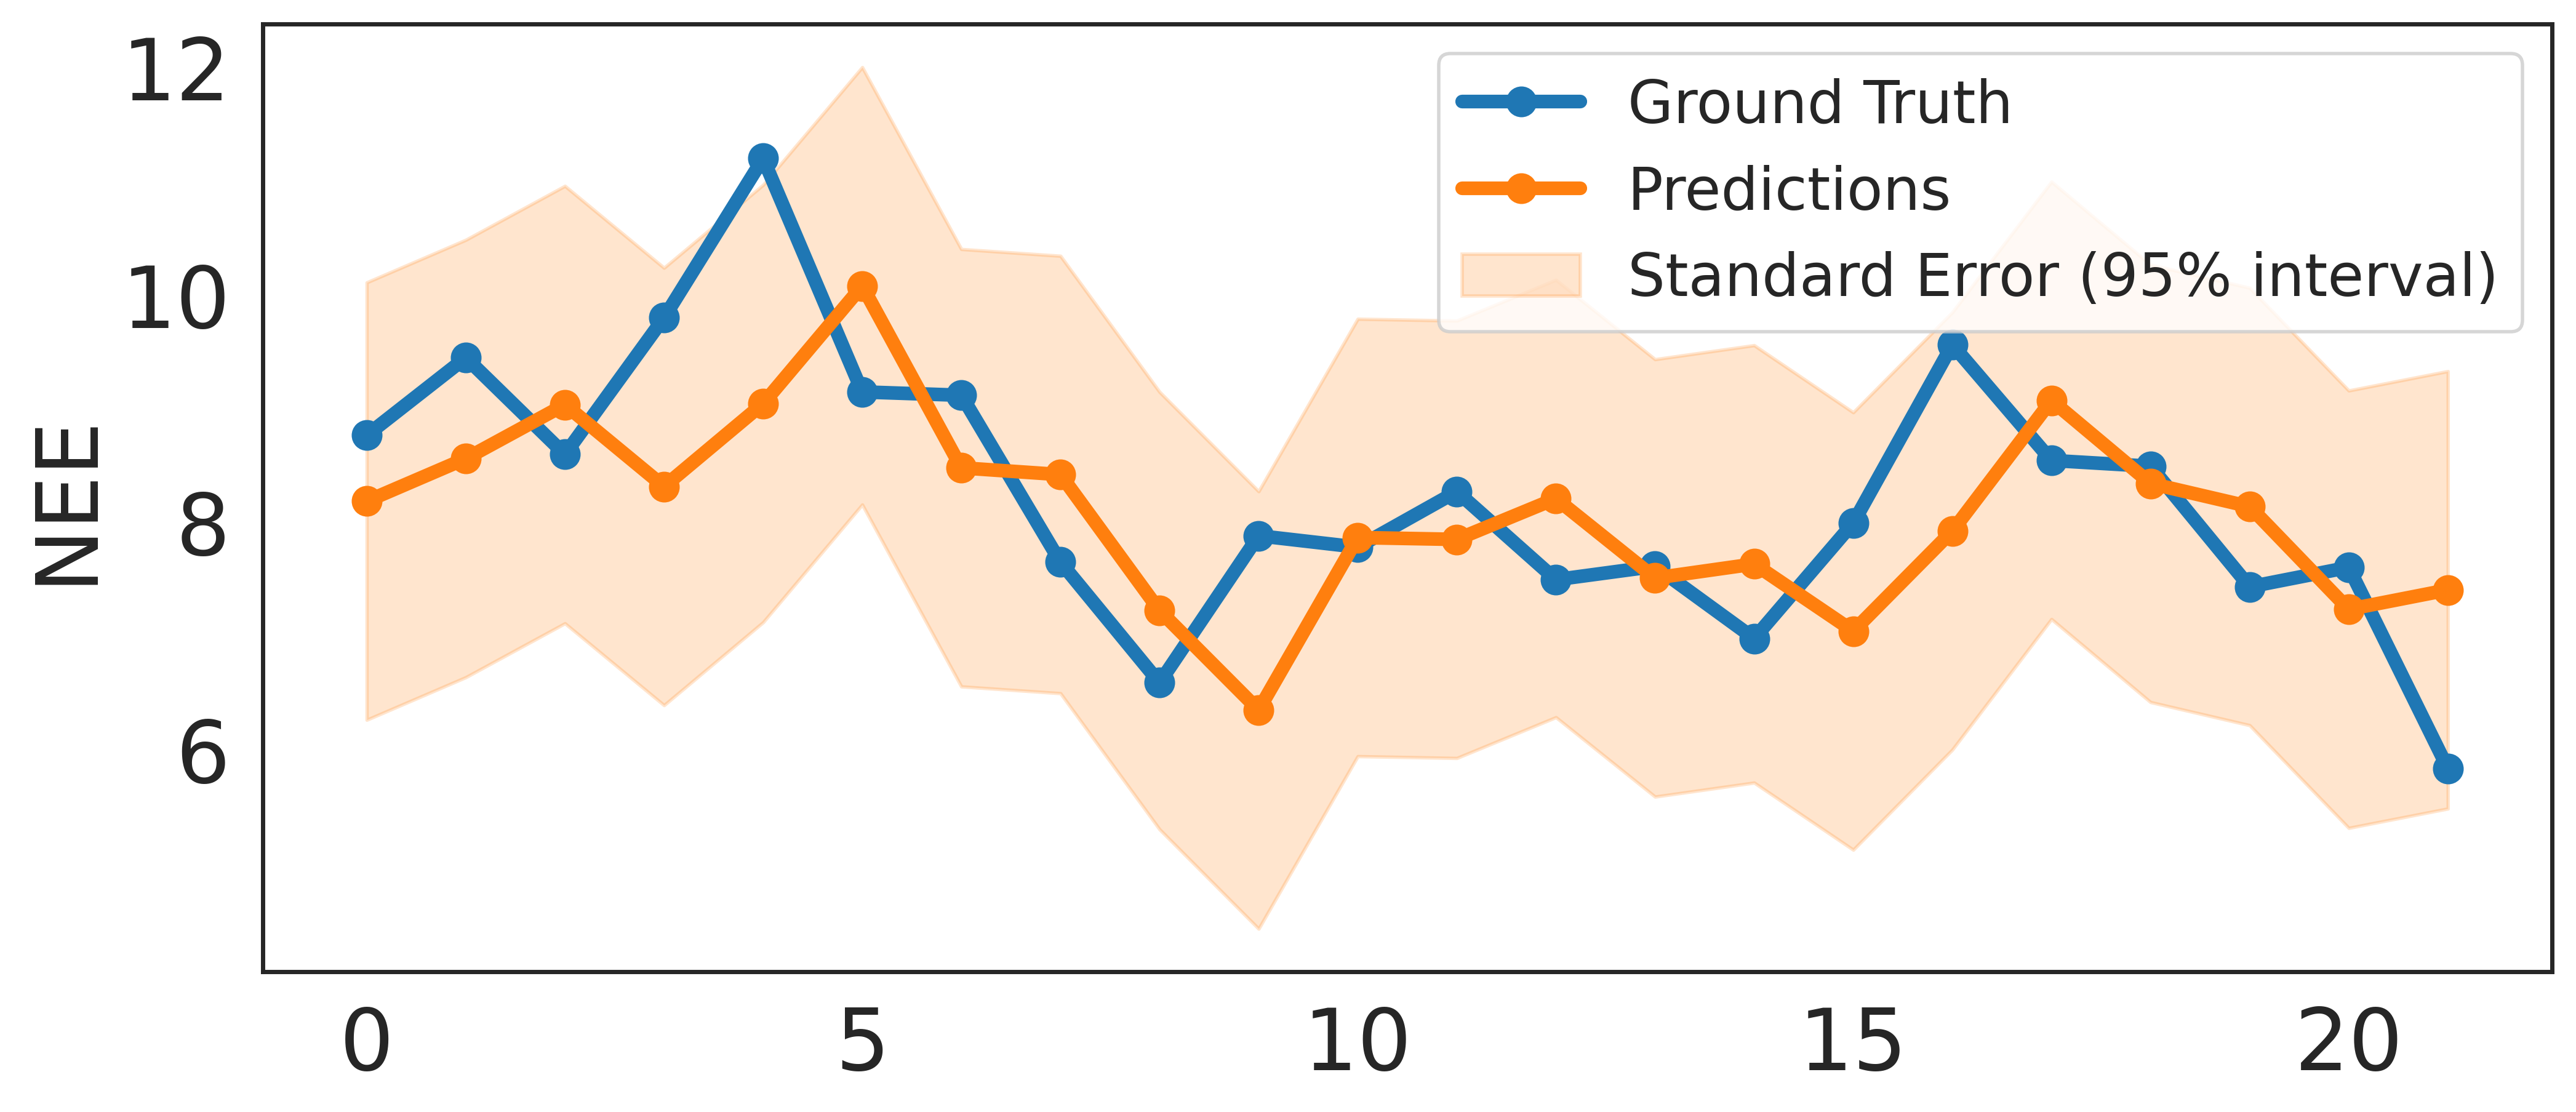

In [70]:
### Daily

test_data['time_diff'] = test_data.DateTime.diff()

test_data['daily_group'] = (test_data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (test_data['daily_group'] == 345).values

date = test_data.DateTime[mask].iloc[0]
date = str(date).split(' ')[0]


gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)
ax.set_ylabel(r"NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

residuals = gt_vis - preds_vis
sigma_residual = np.std(residuals, ddof=1)  # ddof=1 for unbiased estimator
z_score = 1.96  # 95% confidence interval
lower_bound = preds_vis - z_score * sigma_residual
upper_bound = preds_vis + z_score * sigma_residual

plt.fill_between(np.arange(len(preds_vis)), lower_bound, upper_bound, color="#ff7f0e", alpha=0.2, label="95% Prediction Interval")
ax.legend(["Ground Truth", "Predictions", "Standard Error (95% interval)"], fontsize='x-large')
print(date)

# ax.set_title(f"PIAE: NEE Daily Scale ({date})", fontsize=30)
print(date)
fig.savefig("pernn_daily.png", bbox_inches='tight')


2018-11-06 till 2018-11-11


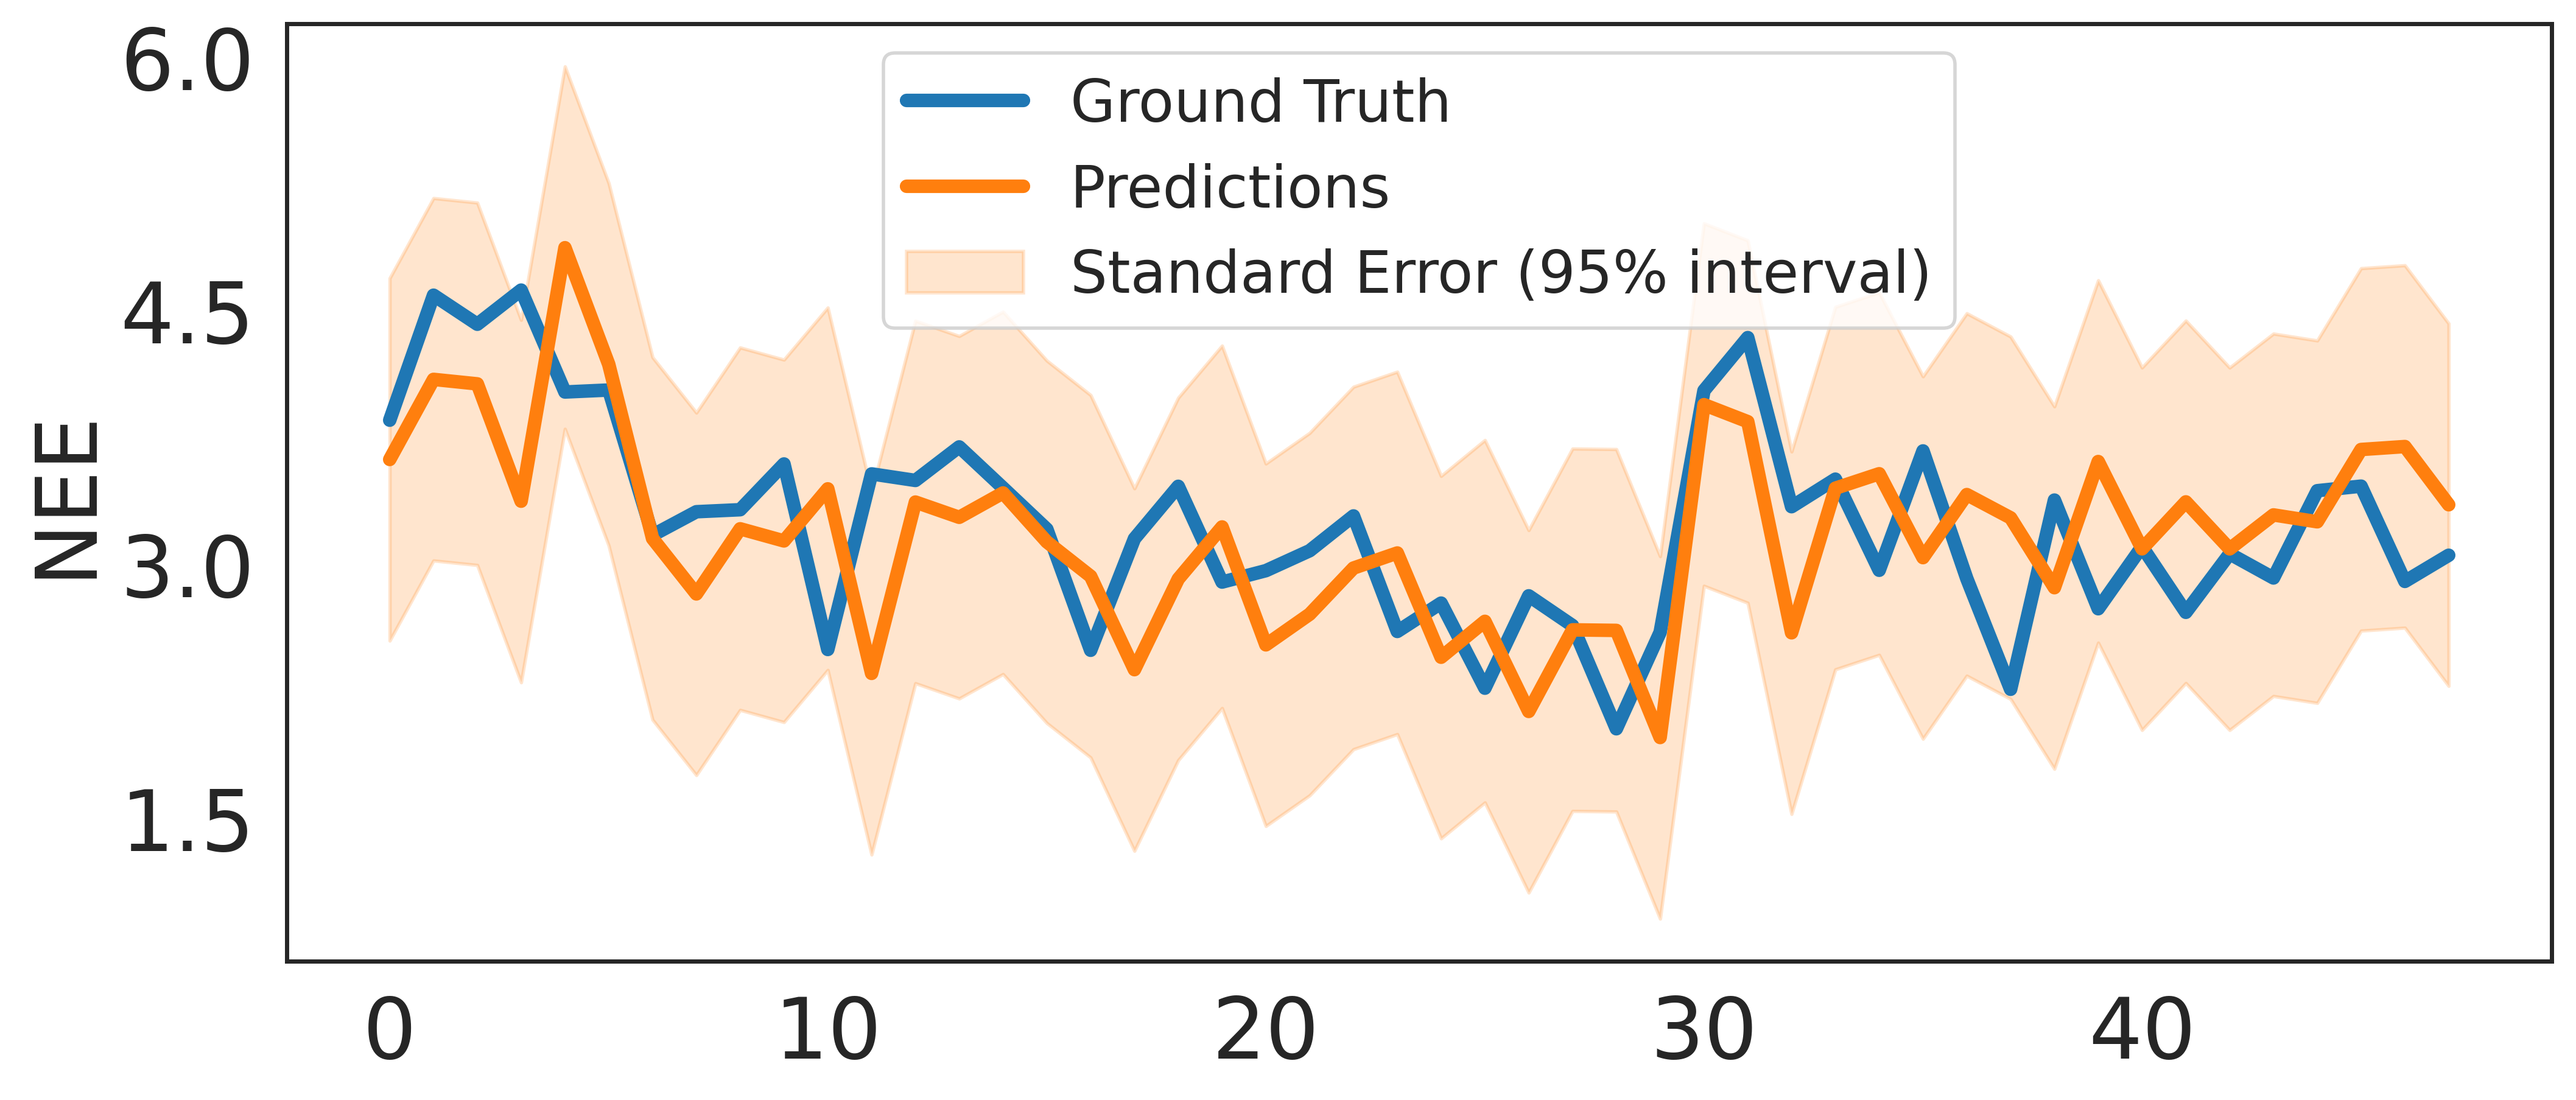

In [80]:
### Weekly

test_data['week_group'] = (test_data['dayofweek'] < test_data['dayofweek'].shift()).cumsum()

mask = test_data.week_group == 12

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()


fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, '-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, '-', color="#ff7f0e", linewidth=4, markersize=8)

residuals = gt_vis - preds_vis
sigma_residual = np.std(residuals, ddof=1)  # ddof=1 for unbiased estimator
z_score = 1.96  # 95% confidence interval
lower_bound = preds_vis - z_score * sigma_residual
upper_bound = preds_vis + z_score * sigma_residual

plt.fill_between(np.arange(len(preds_vis)), lower_bound, upper_bound, color="#ff7f0e", alpha=0.2, label="95% Prediction Interval")


ax.legend(["Ground Truth", "Predictions", "Standard Error (95% interval)"], fontsize='x-large')
ax.set_ylabel(r"NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

print(date)
# ax.set_title(f"PIAE: NEE Weekly Scale ({date})", fontsize=25)
fig.savefig("pernn_weekly.png", bbox_inches='tight')


2019-01-01 till 2019-01-29


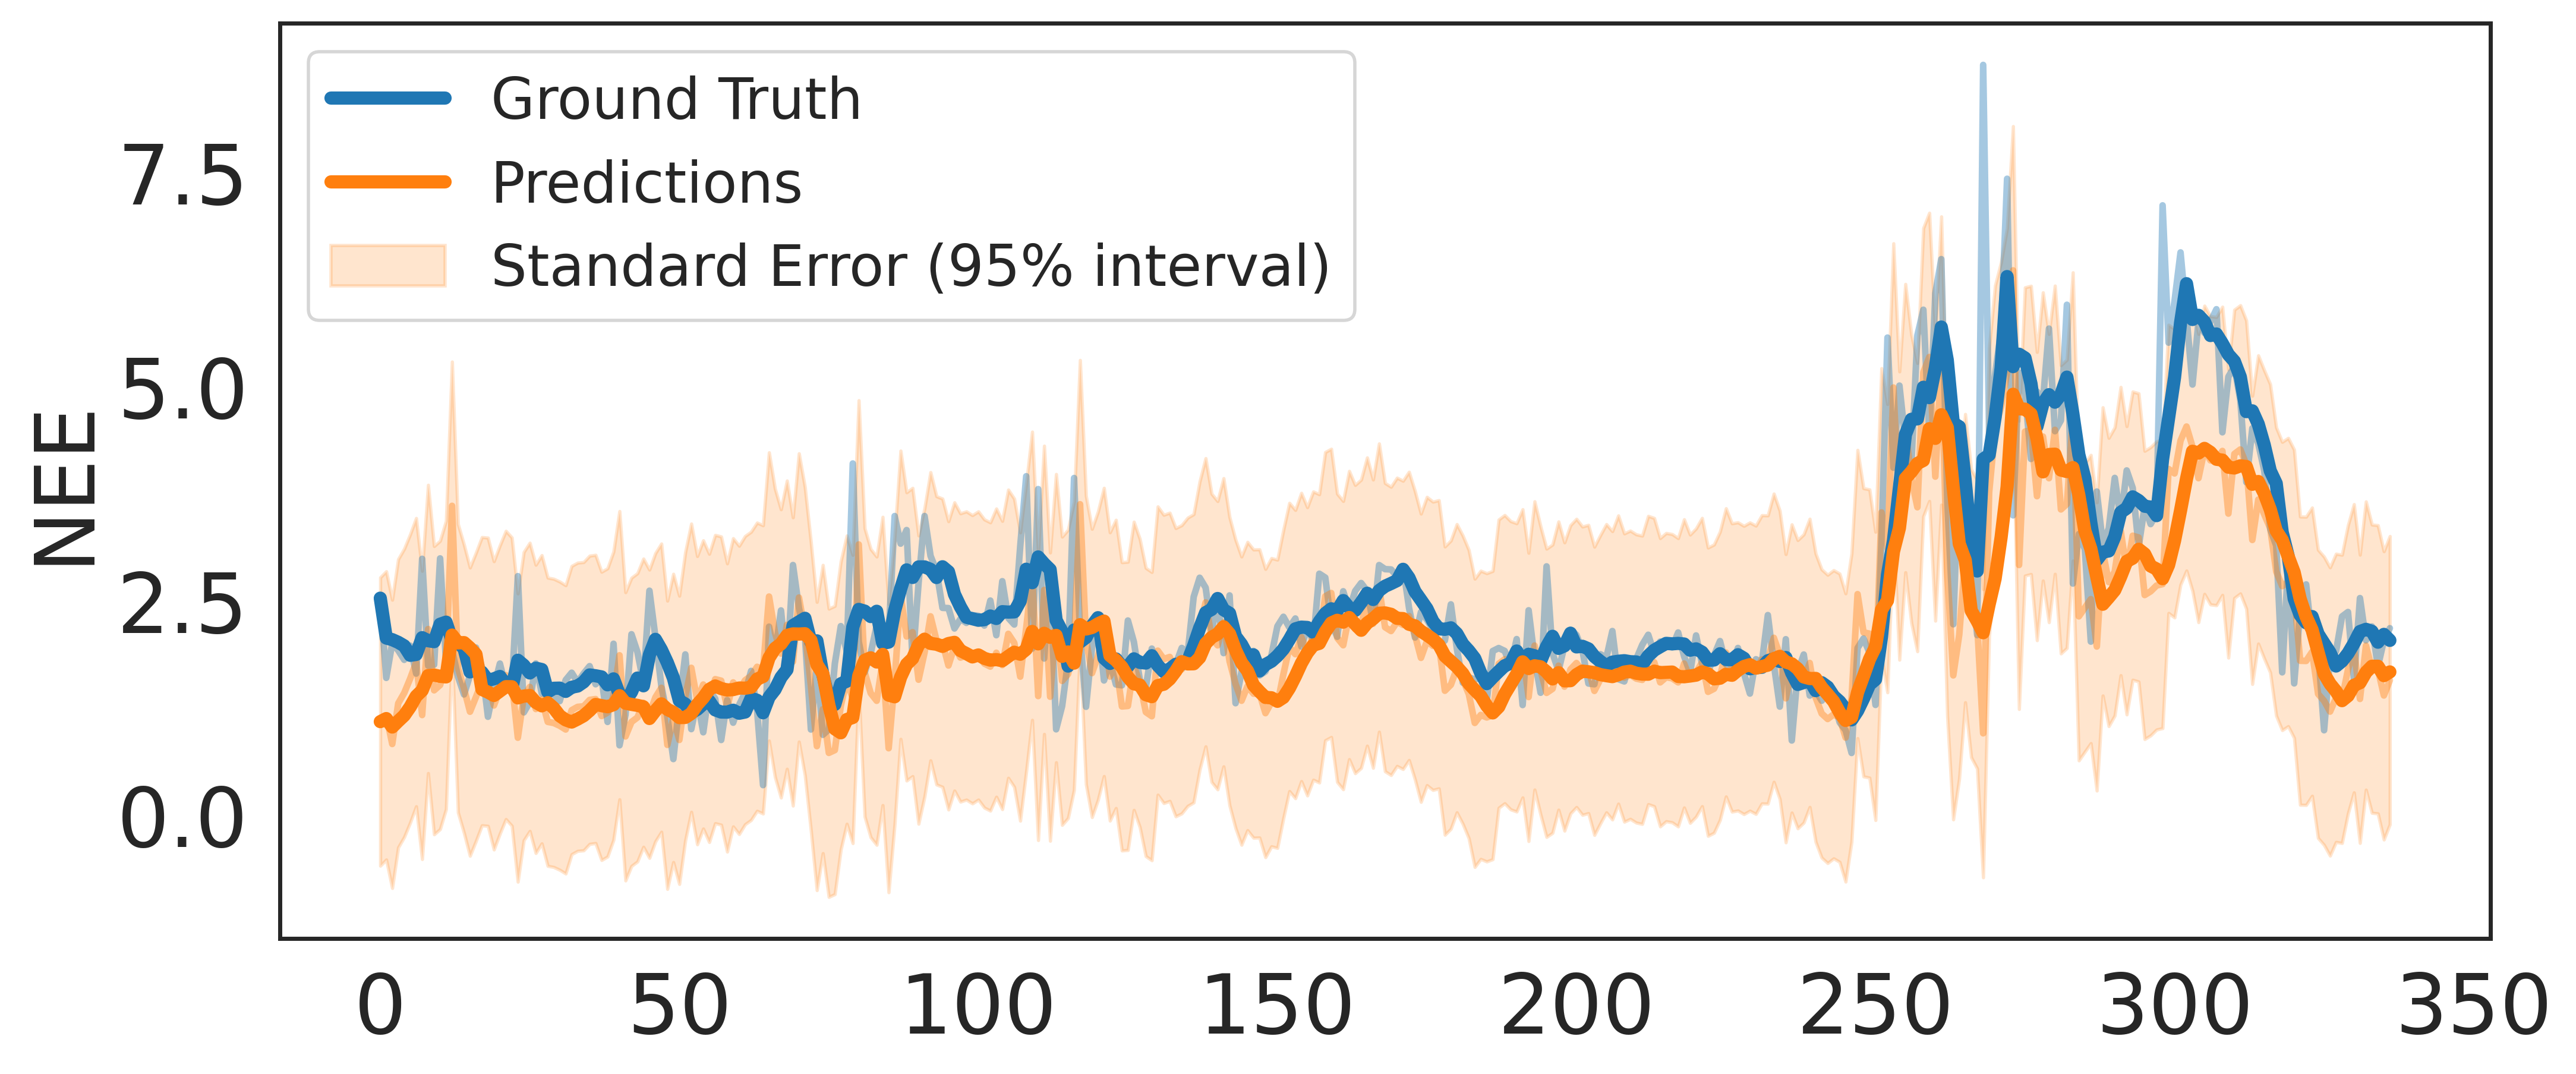

In [83]:
### Monthly

mask = (test_data.DateTime.dt.year == 2019) & (test_data.DateTime.dt.month == 1)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 5
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)

ax.set_ylabel(r"NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

residuals = gt_vis - preds_vis
sigma_residual = np.std(residuals, ddof=1)  # ddof=1 for unbiased estimator
z_score = 1.96  # 95% confidence interval
lower_bound = preds_vis - z_score * sigma_residual
upper_bound = preds_vis + z_score * sigma_residual

plt.fill_between(np.arange(len(preds_vis)), lower_bound, upper_bound, color="#ff7f0e", alpha=0.2, label="Standard Error (95% interval)")

# ax.set_title(f"PIAE: NEE Monthly Scale ({date})", fontsize=25)
ax.legend(fontsize='x-large')
print(date)
fig.savefig("pernn_monthly.png", bbox_inches='tight')

2019-01-01 till 2019-12-30


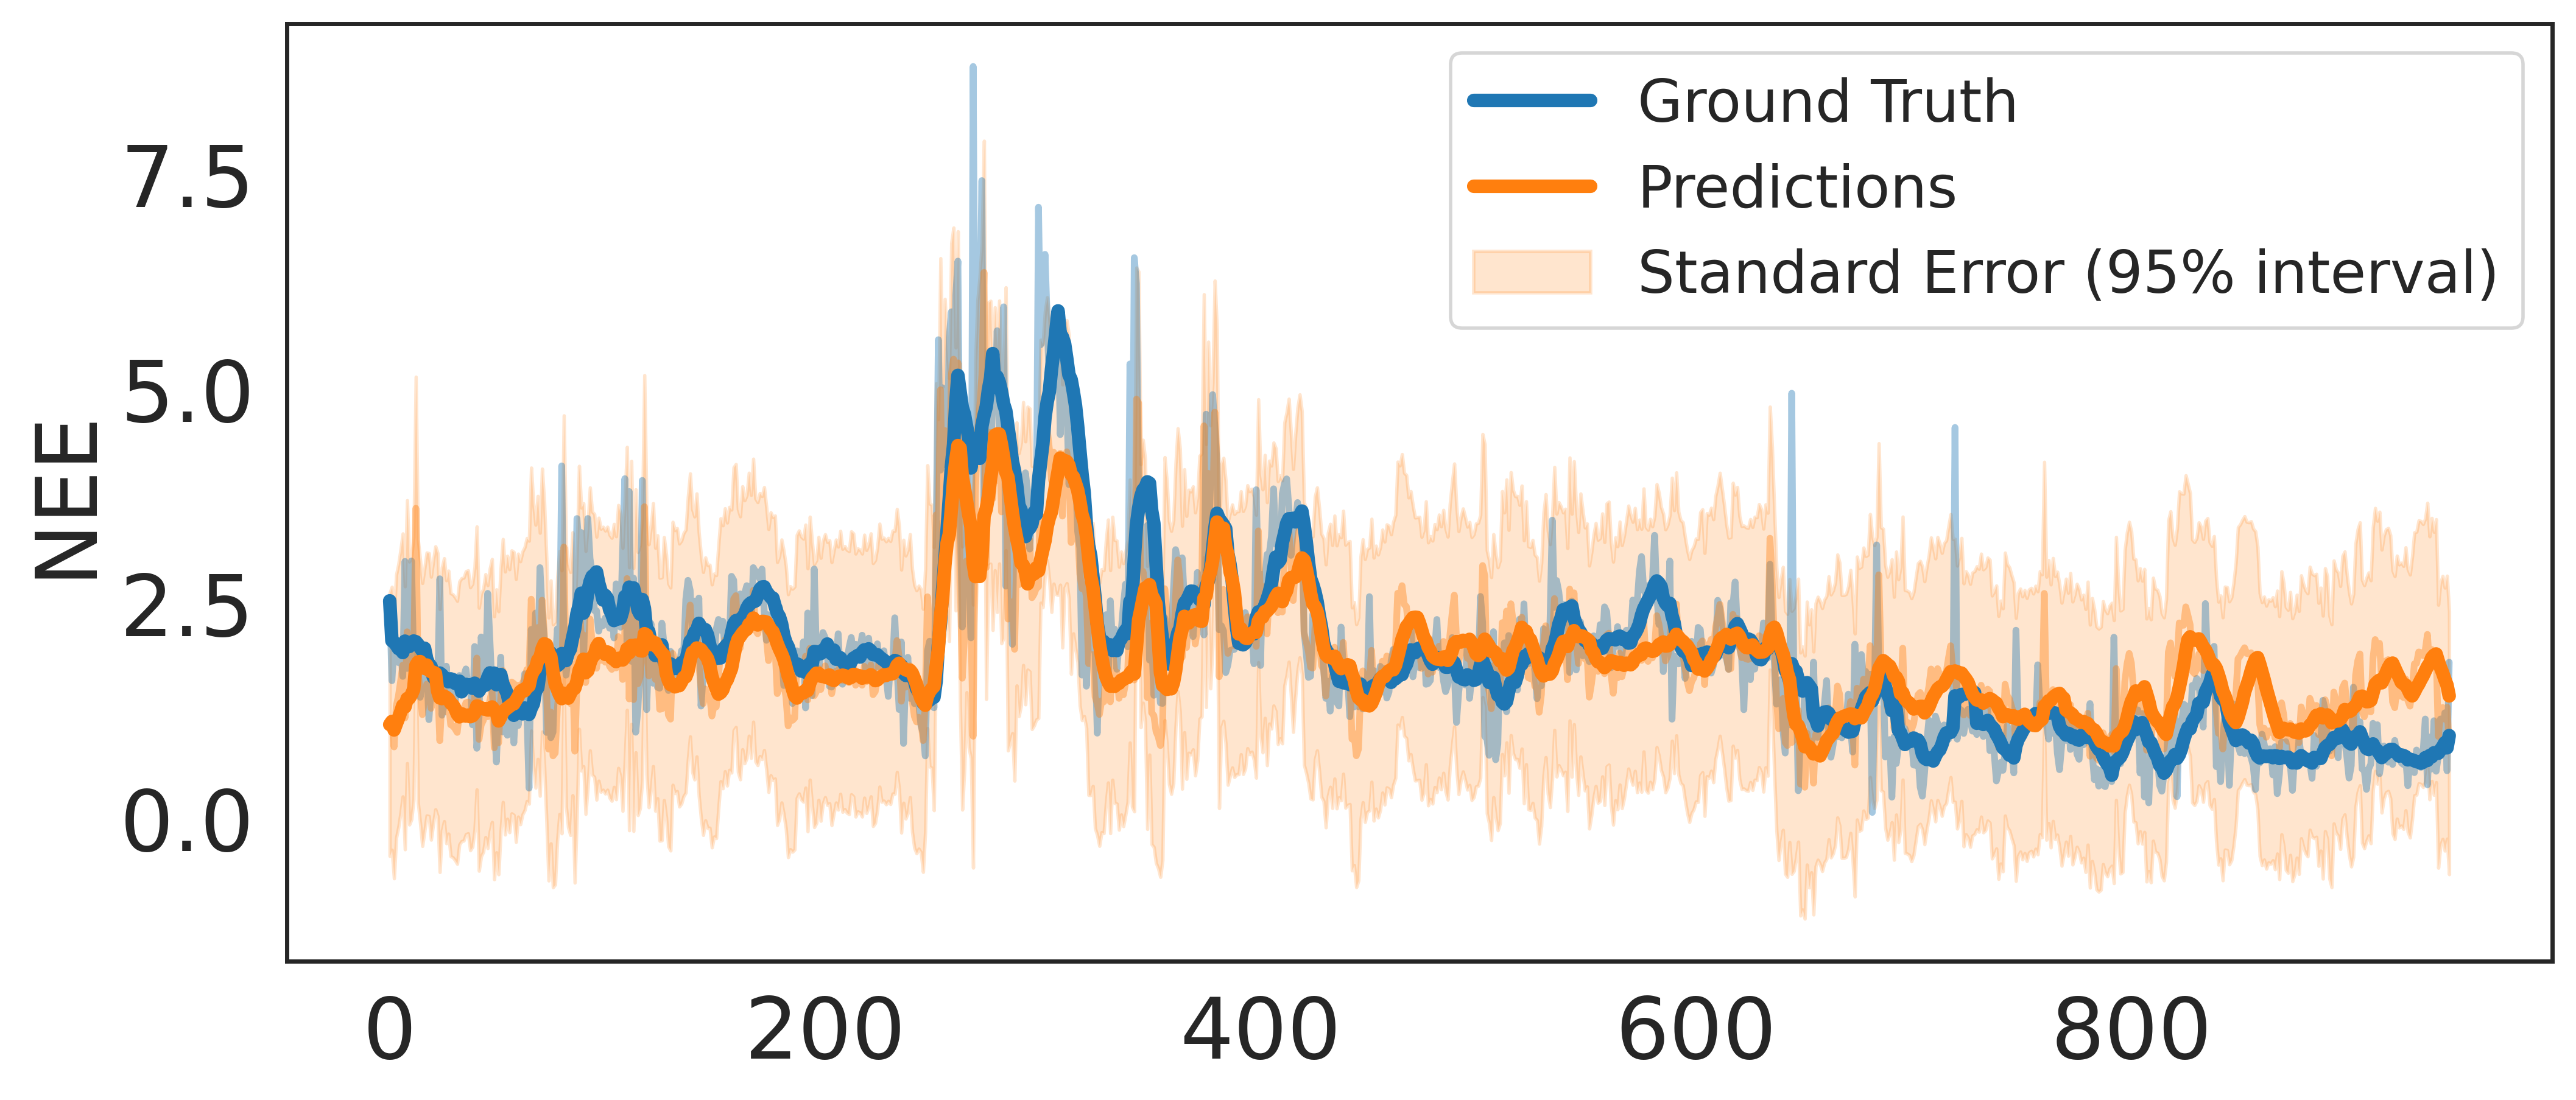

In [86]:
### Quarterly

test_data.season.unique()

mask = (test_data.DateTime.dt.year == 2019) & (test_data.season == 1)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 10
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)
ax.set_ylabel(r"NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

residuals = gt_vis - preds_vis
sigma_residual = np.std(residuals, ddof=1)  # ddof=1 for unbiased estimator
z_score = 1.96  # 95% confidence interval
lower_bound = preds_vis - z_score * sigma_residual
upper_bound = preds_vis + z_score * sigma_residual

plt.fill_between(np.arange(len(preds_vis)), lower_bound, upper_bound, color="#ff7f0e", alpha=0.2, label="Standard Error (95% interval)")

ax.legend(fontsize='x-large')

print(date)
# ax.set_title(f"PIAE: NEE Quarterly Scale ({date})", fontsize=25)
fig.savefig("pernn_quarterly.png", bbox_inches='tight')

/tmp/ipykernel_134195/663086229.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
/tmp/ipykernel_134195/663086229.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(phy, 'go-', color="red", linewidth=4, markersize=8)


2018-08-18 19:30:00


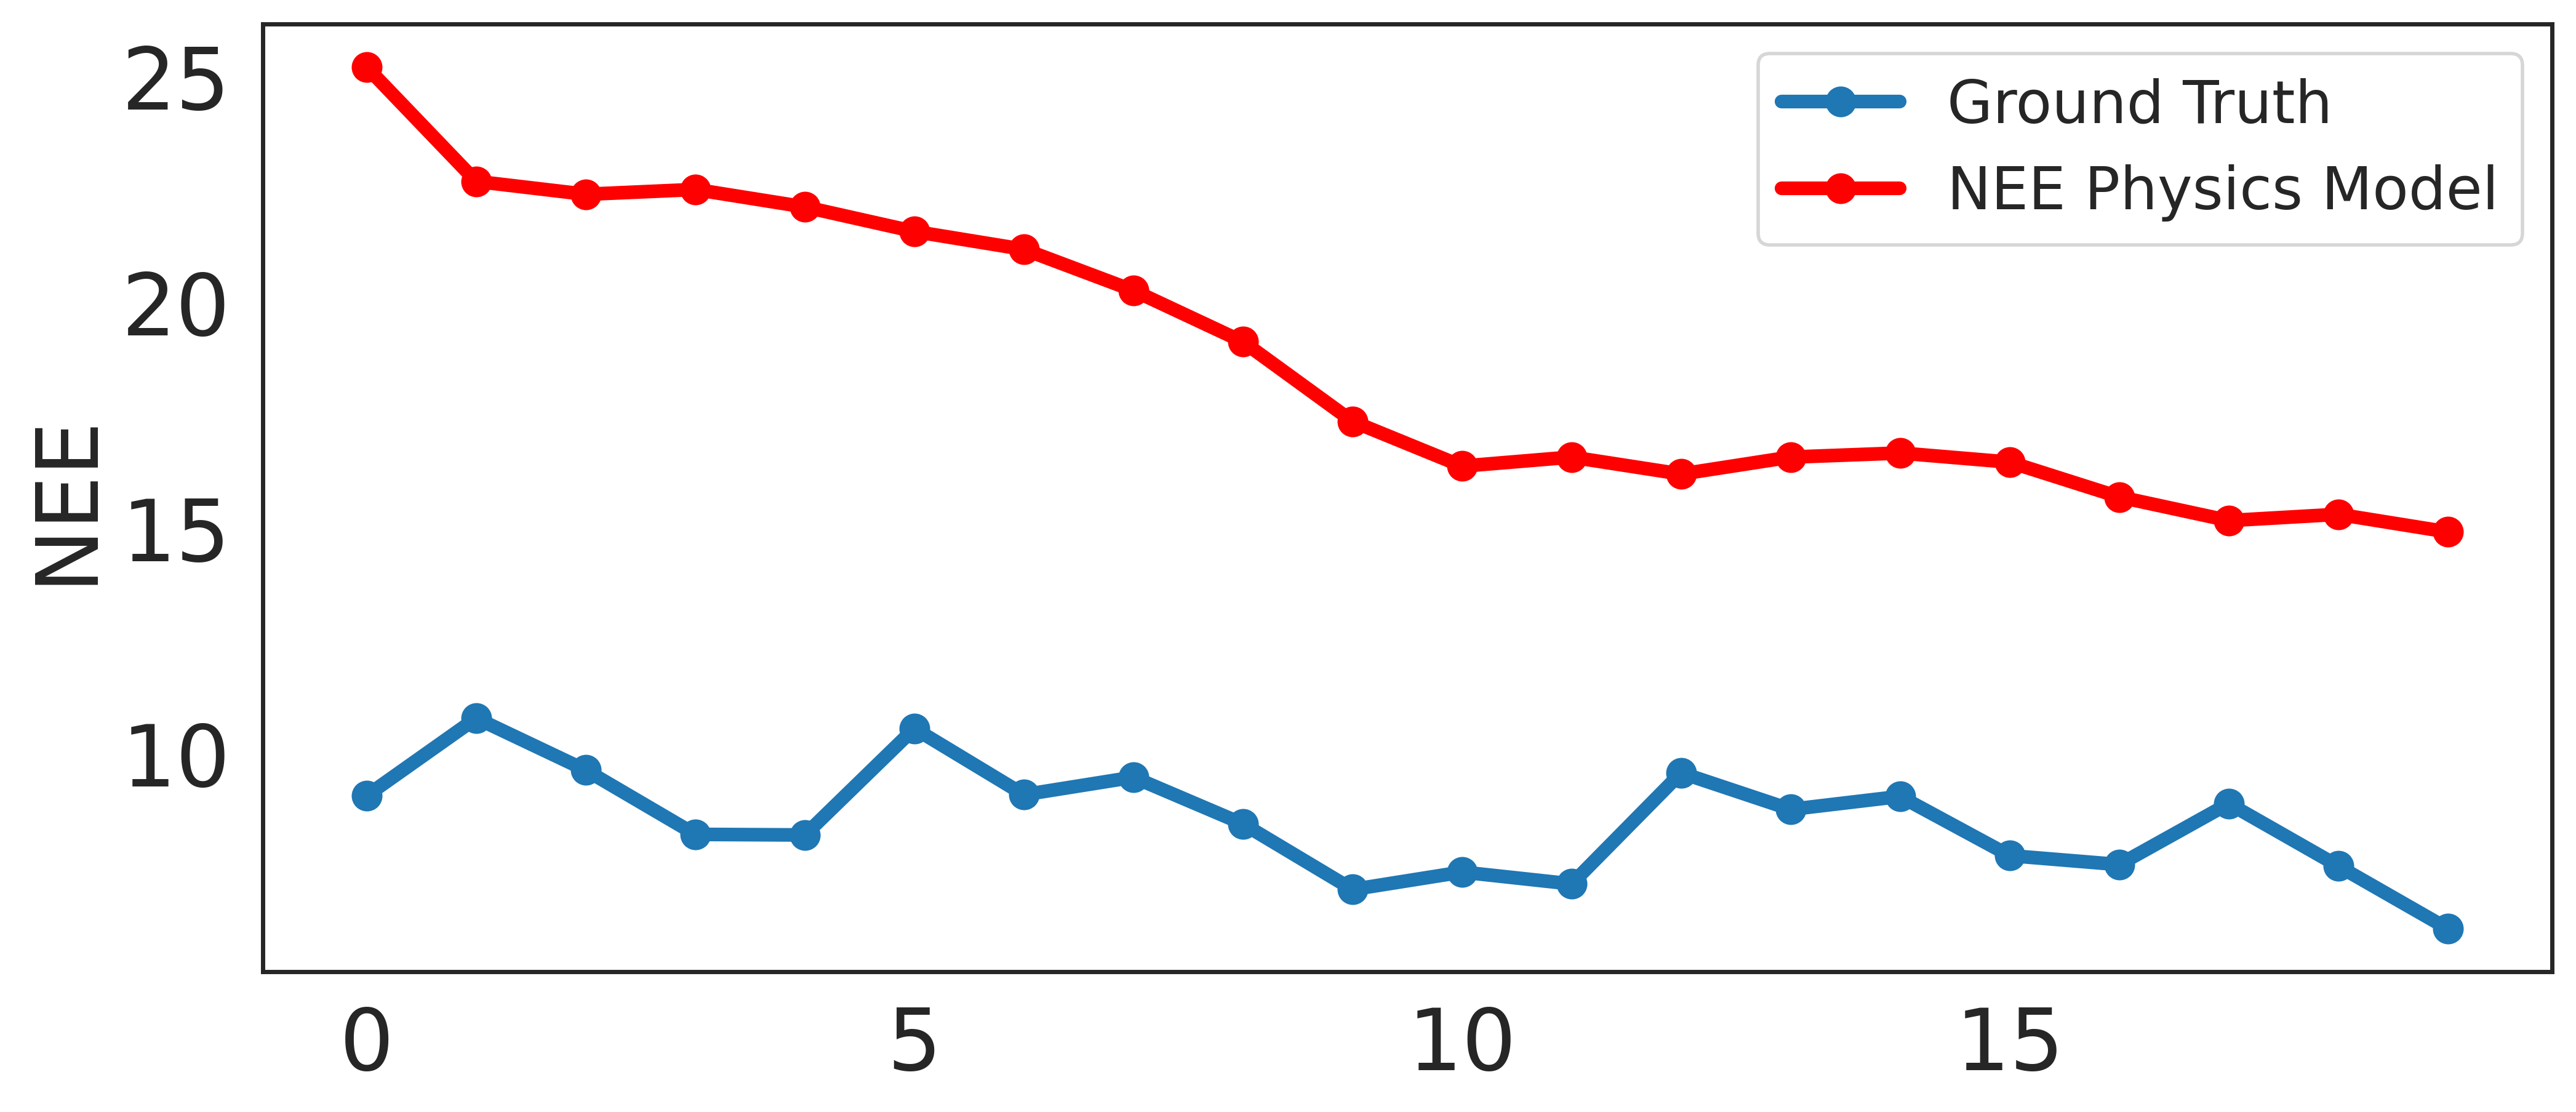

In [97]:
### Daily


test_data['time_diff'] = test_data.DateTime.diff()

test_data['daily_group'] = (test_data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (test_data['daily_group'] == 4).values

date = test_data.DateTime[mask].iloc[0]


gt_vis = gt.nee[mask]
phy = test_data['NEE_phy'][mask].values.flatten() 

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(phy, 'go-', color="red", linewidth=4, markersize=8)


ax.legend(["Ground Truth", "NEE Physics Model"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

#ax.set_title(f"PIAE: NEE Daily Scale ({date})", fontsize=30)

print(date)
fig.savefig("gt_v_phy_1.png", bbox_inches='tight')


/tmp/ipykernel_134195/1118017424.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
/tmp/ipykernel_134195/1118017424.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(phy, 'go-', color="red", linewidth=4, markersize=8)


2019-10-24 18:00:00


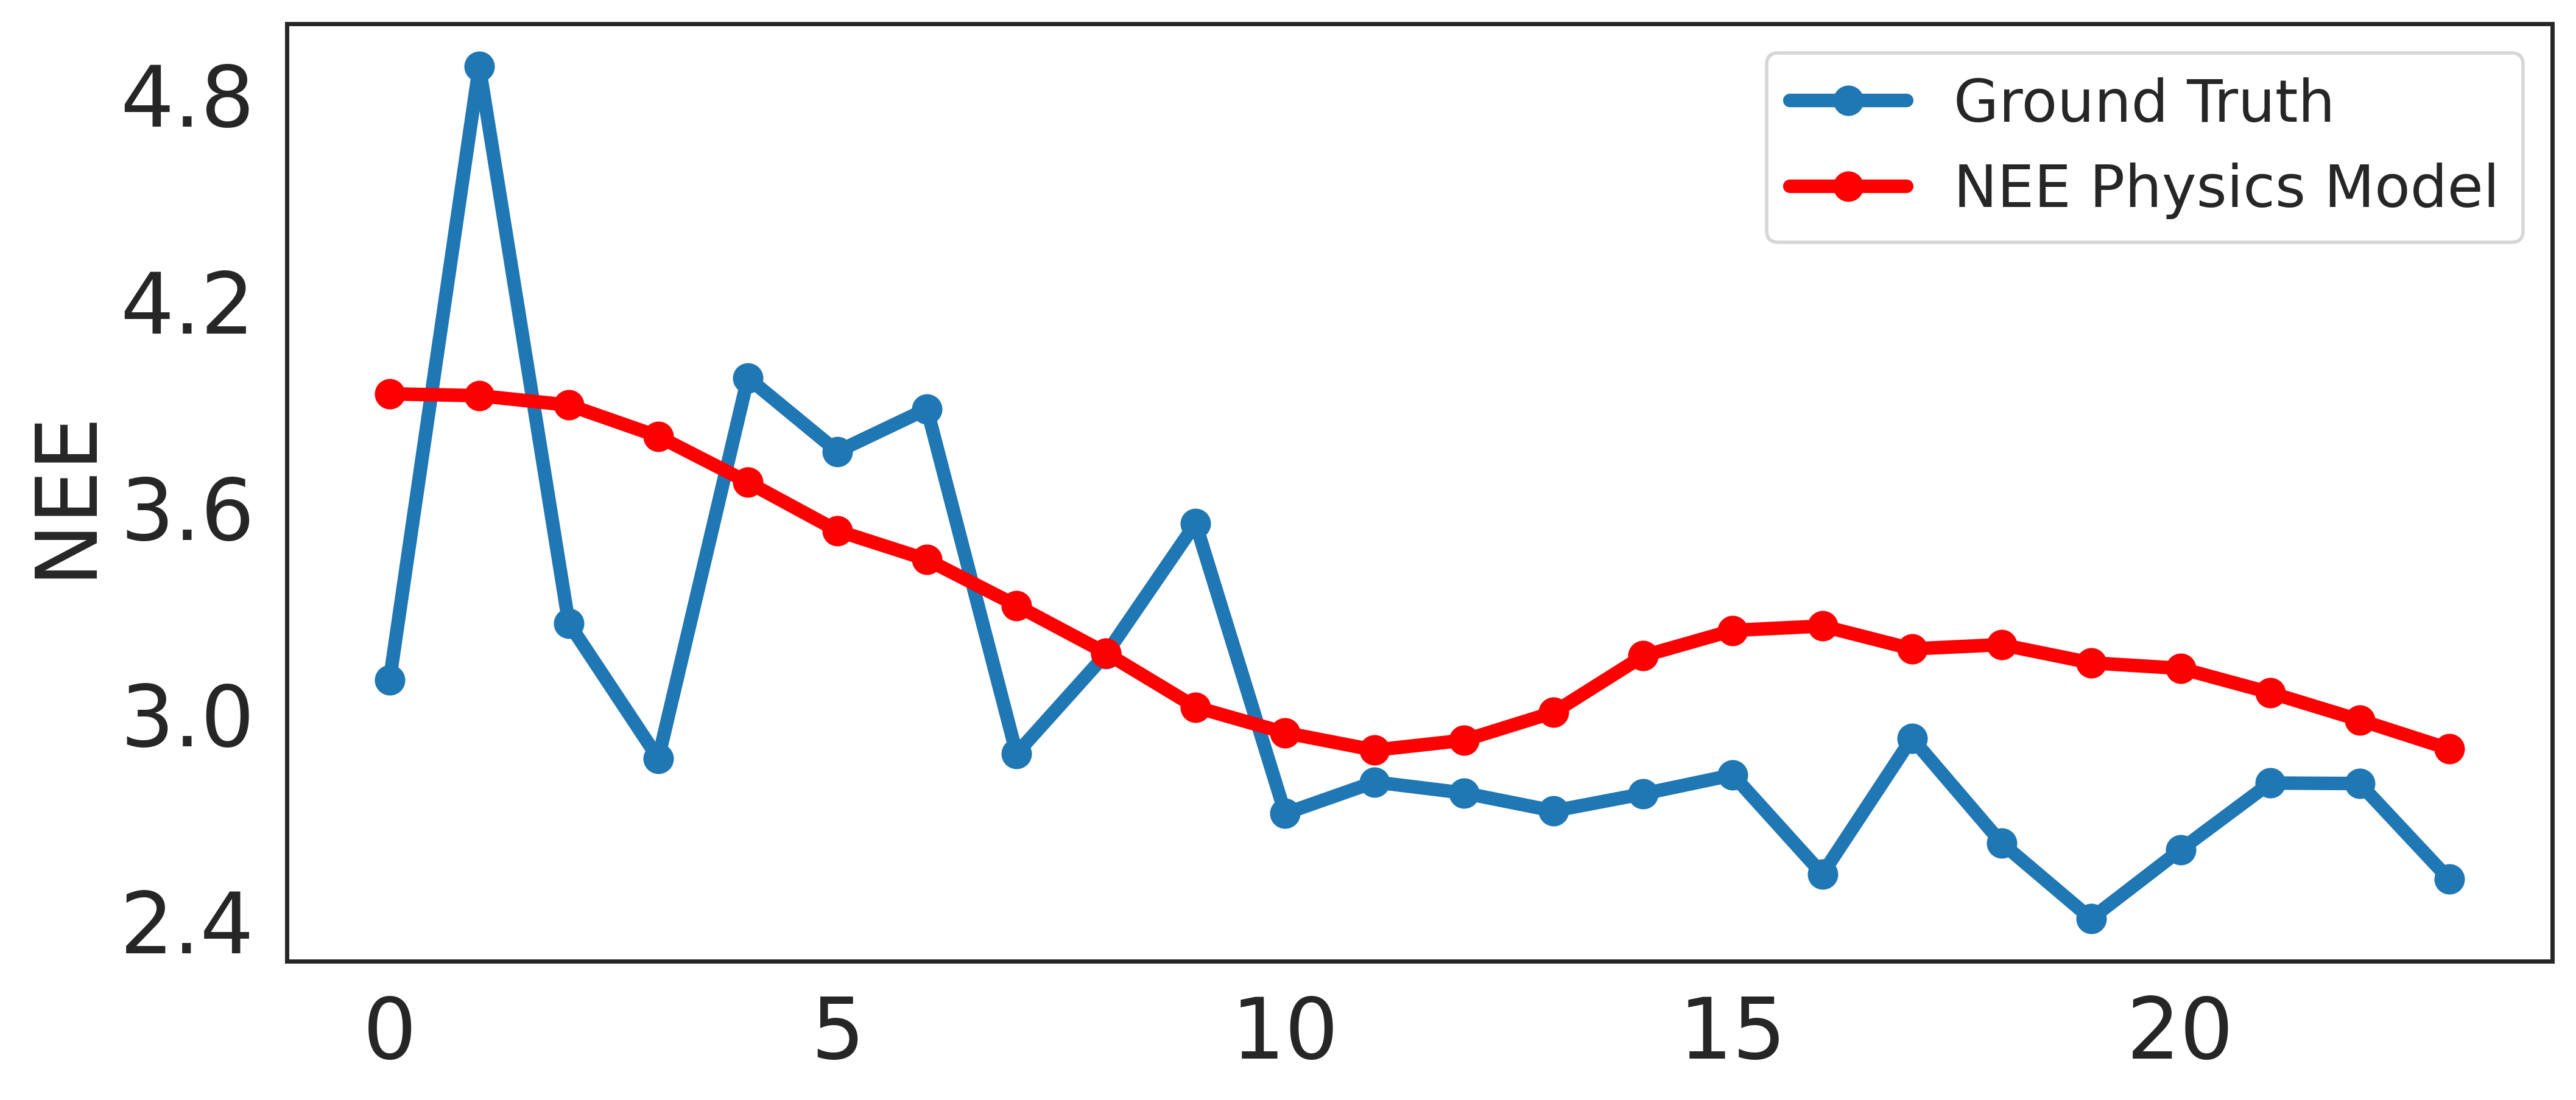

In [90]:
### Daily


test_data['time_diff'] = test_data.DateTime.diff()

test_data['daily_group'] = (test_data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (test_data['daily_group'] == 379).values

date = test_data.DateTime[mask].iloc[0]


gt_vis = gt.nee[mask]
phy = test_data['NEE_phy'][mask].values.flatten() 

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(phy, 'go-', color="red", linewidth=4, markersize=8)


ax.legend(["Ground Truth", "NEE Physics Model"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

#ax.set_title(f"PIAE: NEE Daily Scale ({date})", fontsize=30)

print(date)
fig.savefig("gt_v_phy_2.png", bbox_inches='tight')


/tmp/ipykernel_134195/179563266.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
/tmp/ipykernel_134195/179563266.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(phy, 'go-', color="red", linewidth=4, markersize=8)


2019-03-04 18:30:00


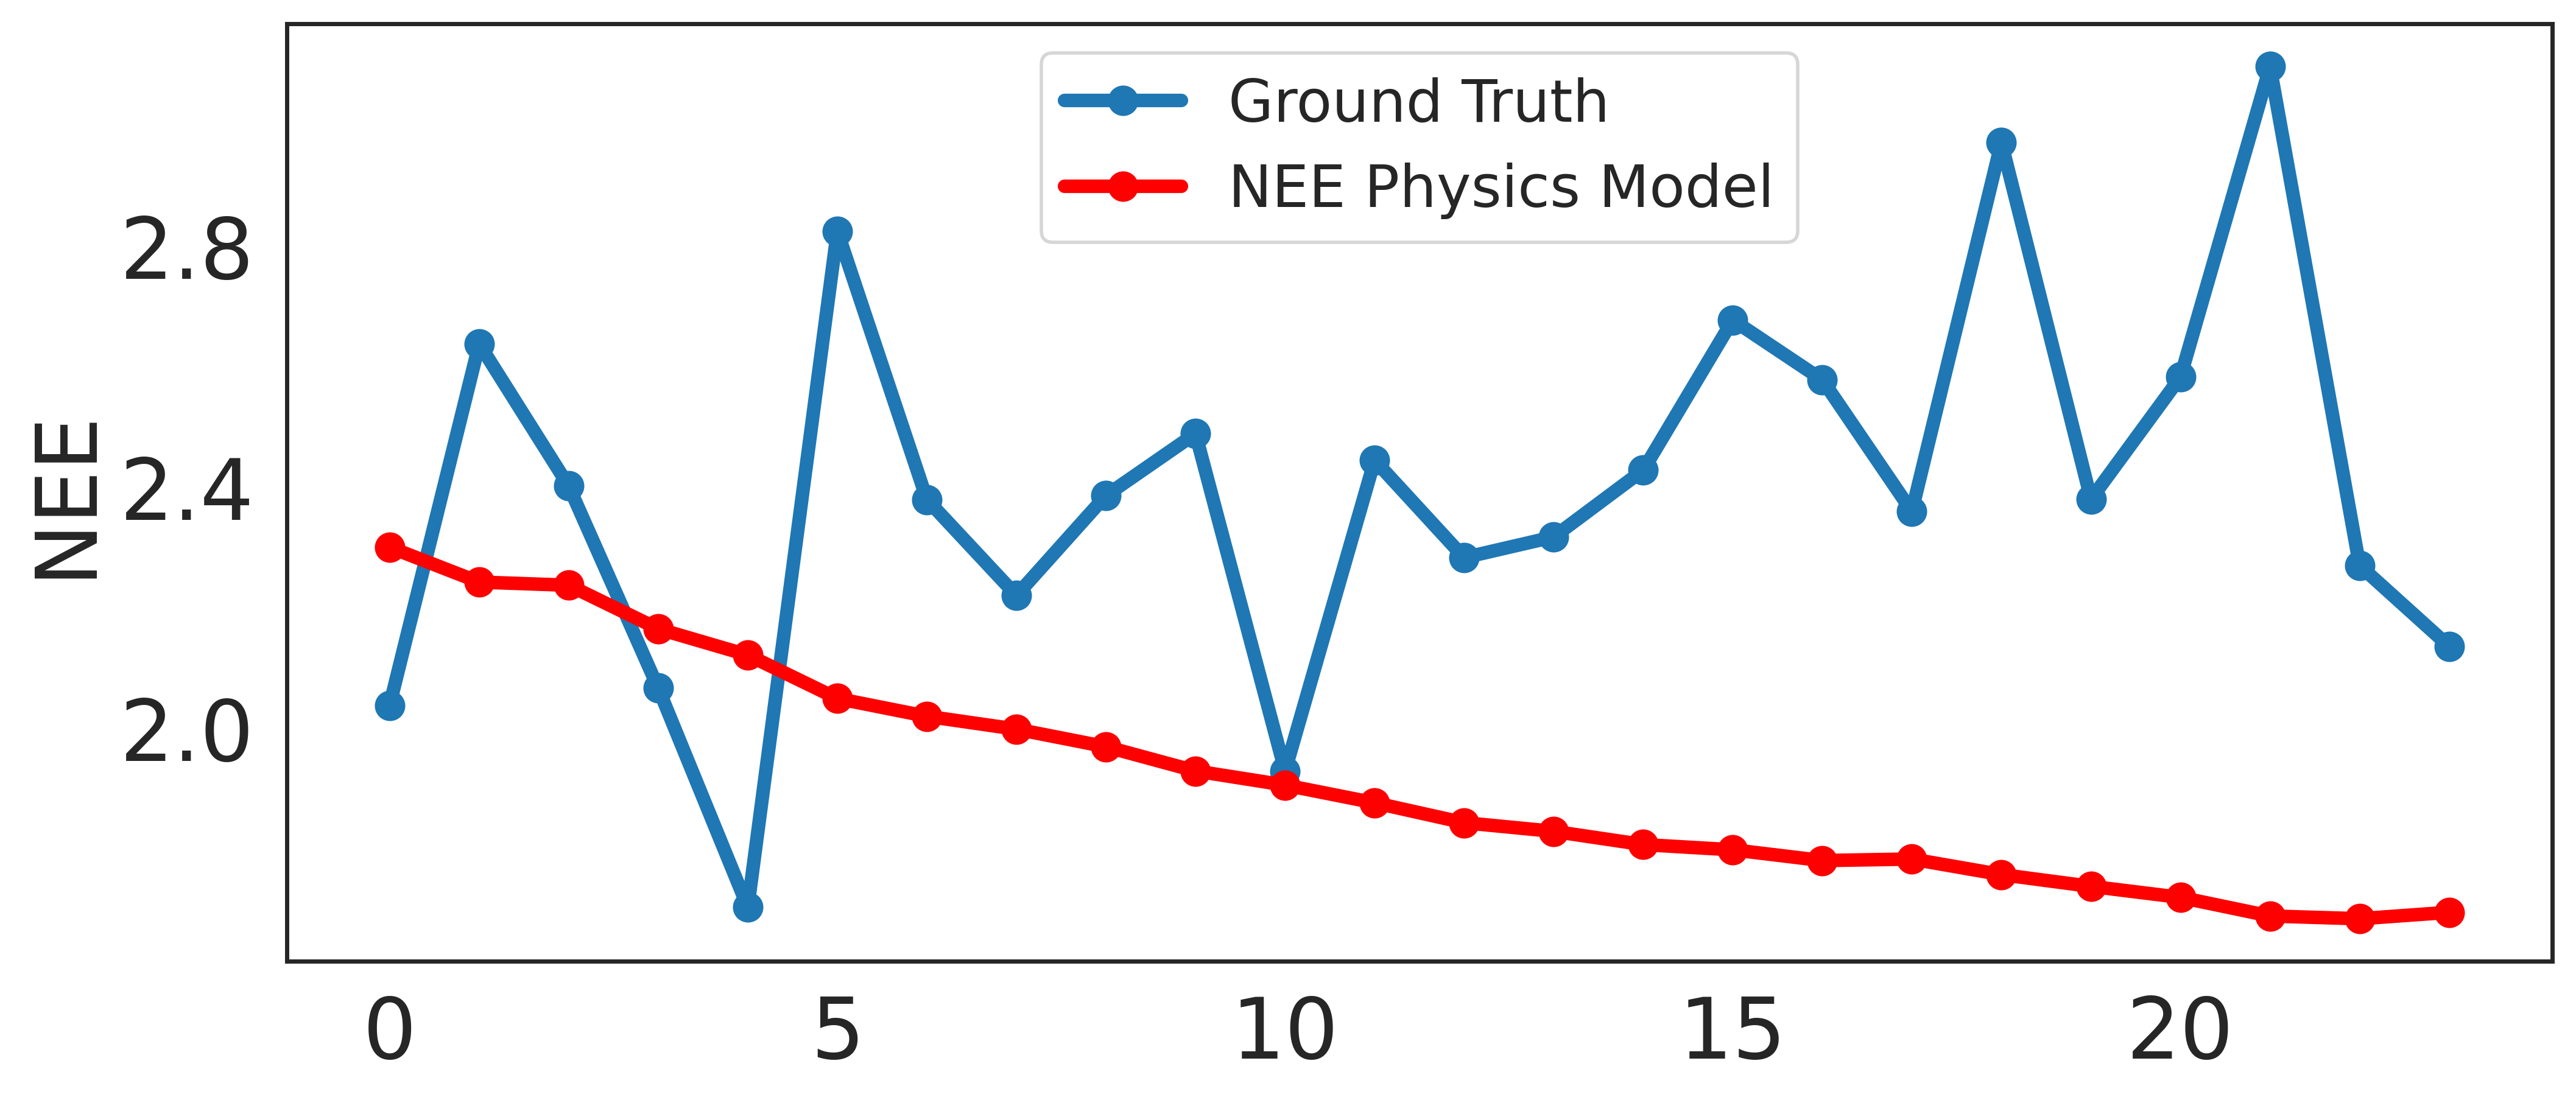

In [91]:
### Daily


test_data['time_diff'] = test_data.DateTime.diff()

test_data['daily_group'] = (test_data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (test_data['daily_group'] == 190).values

date = test_data.DateTime[mask].iloc[0]


gt_vis = gt.nee[mask]
phy = test_data['NEE_phy'][mask].values.flatten() 

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(phy, 'go-', color="red", linewidth=4, markersize=8)


ax.legend(["Ground Truth", "NEE Physics Model"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

#ax.set_title(f"PIAE: NEE Daily Scale ({date})", fontsize=30)

print(date)
fig.savefig("gt_v_phy_3.png", bbox_inches='tight')


/tmp/ipykernel_134195/2265316586.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
/tmp/ipykernel_134195/2265316586.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(phy, 'go-', color="red", linewidth=4, markersize=8)


2019-08-21 19:30:00


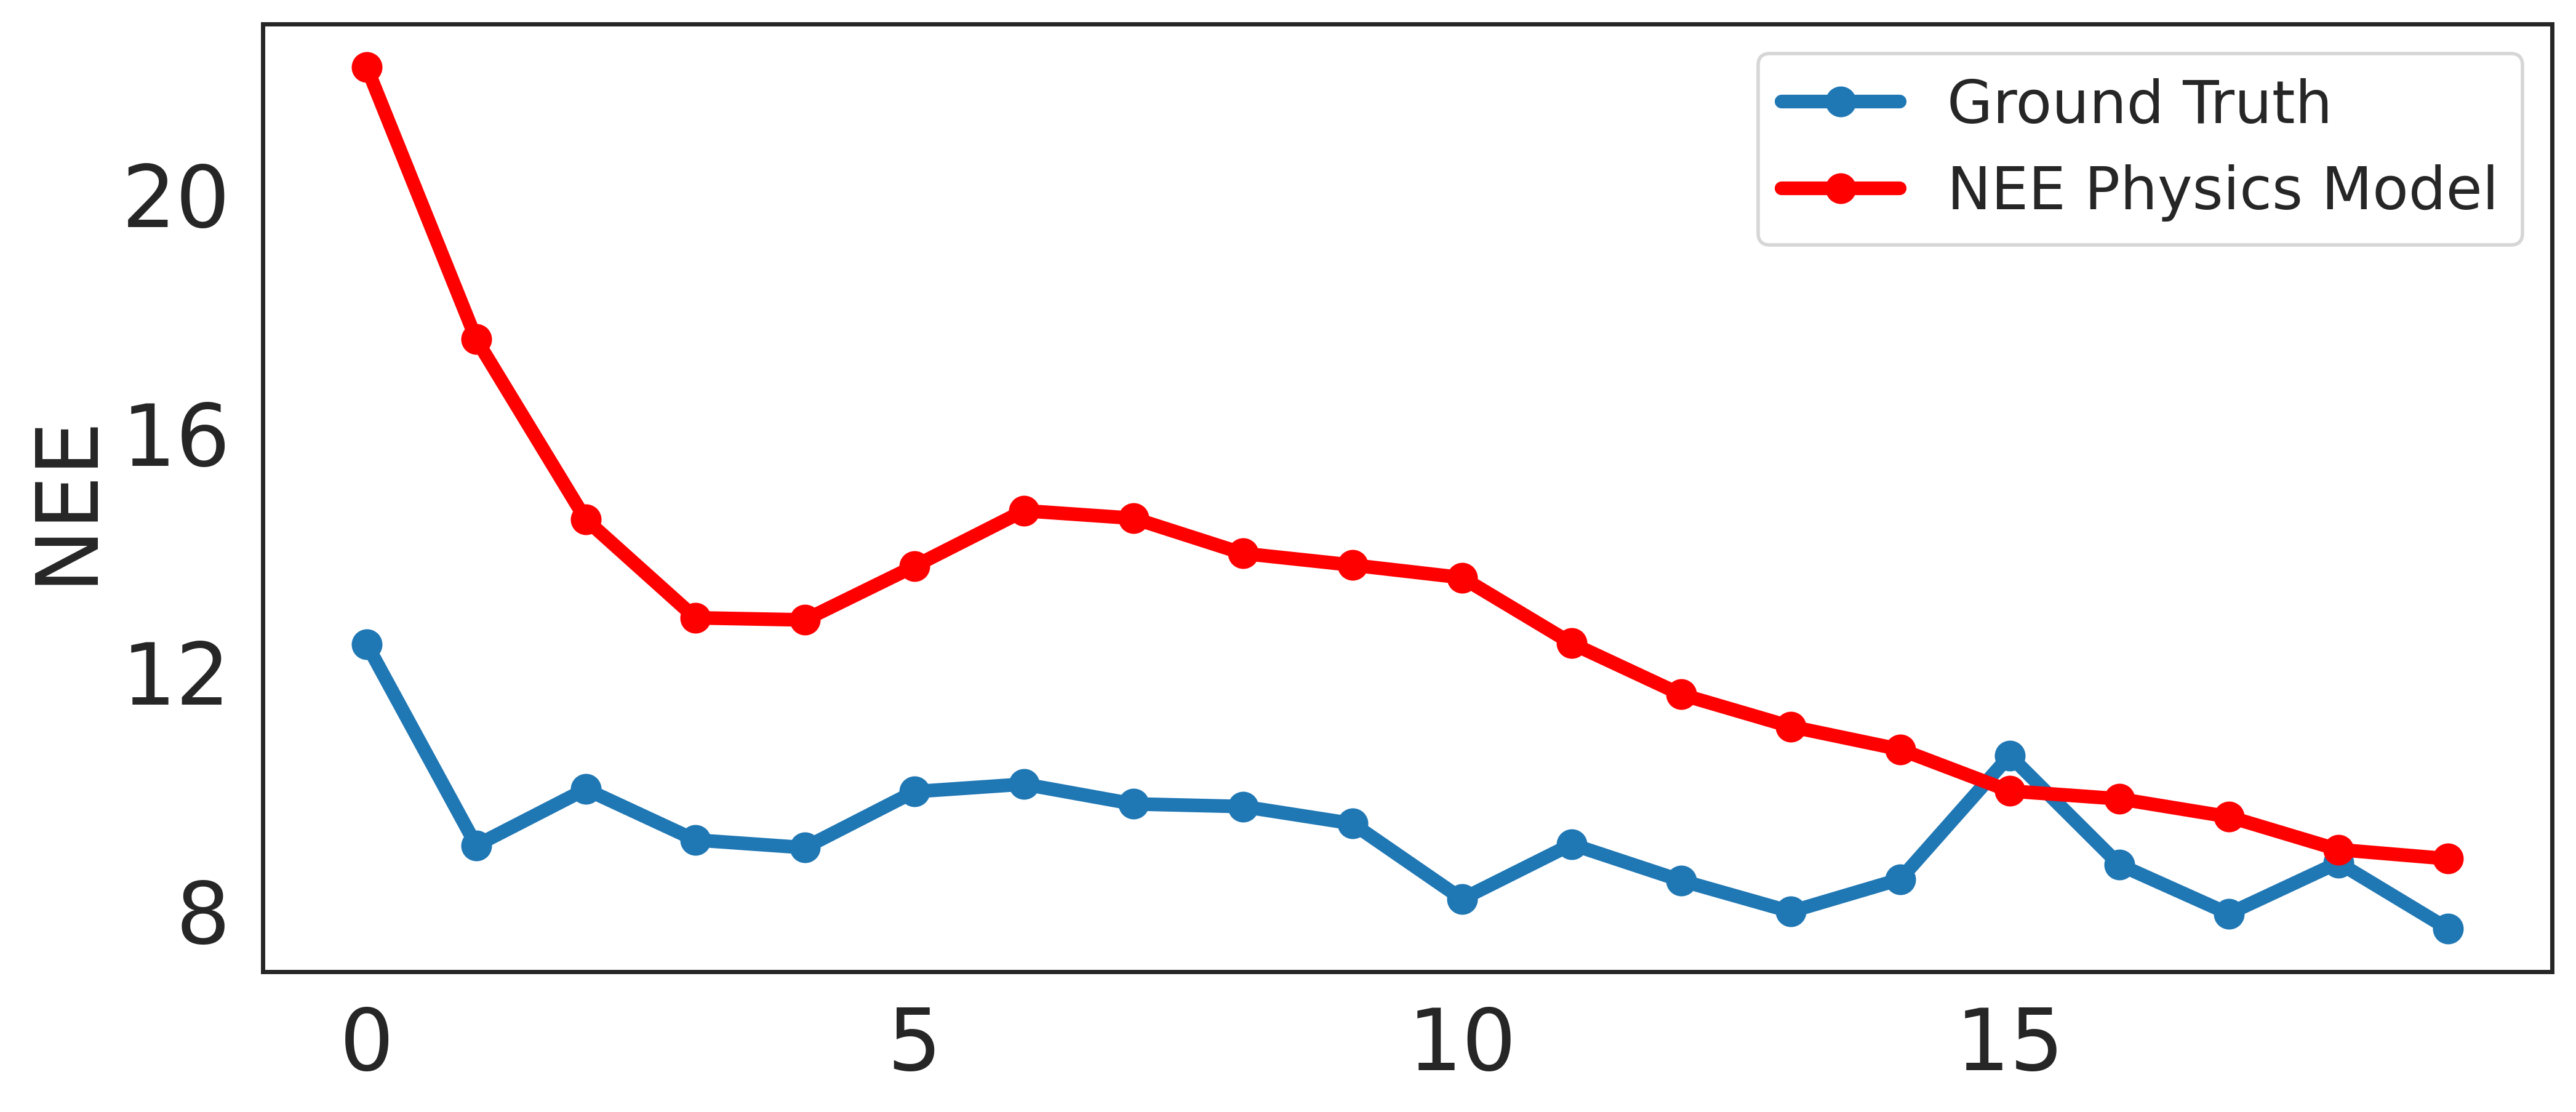

In [92]:
### Daily


test_data['time_diff'] = test_data.DateTime.diff()

test_data['daily_group'] = (test_data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (test_data['daily_group'] == 323).values

date = test_data.DateTime[mask].iloc[0]


gt_vis = gt.nee[mask]
phy = test_data['NEE_phy'][mask].values.flatten() 

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(phy, 'go-', color="red", linewidth=4, markersize=8)


ax.legend(["Ground Truth", "NEE Physics Model"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

#ax.set_title(f"PIAE: NEE Daily Scale ({date})", fontsize=30)

print(date)
fig.savefig("gt_v_phy_4.png", bbox_inches='tight')
